# **<p style="text-align: center;"> Предсказание активности покупателей.</p>**

В проекте представлена информация по трем интернет-магазинам: мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц, магазин одежды, маленький магазин подарков.
Цель проекта:
Создать решение для предсказания, совершит ли покупатель повторную покупку в течение ближайших 30 дней

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from datetime import timedelta

from datetime import datetime
from sklearn.model_selection import  StratifiedKFold, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score,f1_score,precision_score, recall_score
from catboost import cv, Pool
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier

## Изучим предоставленные данные  в магазине одежды, по характеристикам похожий на маркетплейс.

**Цель:**
**Предсказание повторной покупки в течение 30 дней после заказа (временной ряд, классификация)**

In [4]:
apparel_df = pd.read_csv('data/apparel-purchases.csv')

In [5]:
apparel_df.head()

,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
3,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
4,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message


Столбцы recommended_by и message_id содержат значение bulk_message и идентификатор сообщения из рассылки,это признаки,которые не влияют на целевую переменную,не предоставляют полезной информации, их удаление улучшит производительность модели и упростит анализ данных.

In [6]:
apparel_df = apparel_df.drop(columns=['recommended_by','message_id'])

In [7]:
apparel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   client_id  133104 non-null  int64  
 1   quantity   133104 non-null  int64  
 2   price      133104 non-null  float64
 3   date       133104 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 4.1+ MB


In [8]:
apparel_df['date'] = pd.to_datetime(apparel_df['date'])

In [9]:
print("Минимальная дата:", apparel_df['date'].min())
print("Максимальная дата:", apparel_df['date'].max())

Минимальная дата: 2022-10-26 00:00:00
Максимальная дата: 2023-10-26 00:00:00


В датафрейме данные о покупках представлены ровно за один календарный год.

In [10]:
# Упорядочиваем датасет по дате и клиенту
apparel_df_sorted = apparel_df.sort_values(by=['date', 'client_id'])

# Группируем по клиенту и дате, суммируем количество и сумму цен
apparel_total_df = apparel_df_sorted.groupby(['date', 'client_id']).agg({
    'quantity': 'sum',
    'price': 'sum'
}).reset_index()

apparel_total_df = apparel_total_df.rename(columns={'quantity': 'quantity_total', 'price': 'price_total'})

# Убеждаемся, что новый датафрейм создан корректно
apparel_total_df.head()

,date,client_id,quantity_total,price_total
0,2022-10-26,1515915625468222486,2,7998.0
1,2022-10-26,1515915625489888679,3,2213.0
2,2022-10-26,1515915625500418210,1,1859.0
3,2022-10-26,1515915625558655965,3,3298.0
4,2022-10-26,1515915625581772632,1,2100.0


### Cоздадим временные признаки, нарастающим итогом для обучения модели

Добавим новые столбцы: month, в котором для каждой даты указывается соответствующий месяц и столбцы,в которых указано кумулятивное количество заказов и цены для каждого клиента на каждый месяц.

In [11]:
apparel_total_df['month'] = apparel_total_df['date'].dt.to_period('M')

# Создаем кумулятивные суммы для количества заказов по месяцам
apparel_total_df['orders_per_month'] = apparel_total_df.groupby(['client_id', 'month']).cumcount() + 1

In [12]:
# Создаем кумулятивные суммы для суммы заказов по месяцам
apparel_total_df['price_per_month'] = (apparel_total_df.groupby(['client_id', 'month'])['price_total'].cumsum())

Добавим новый столбец orders_per_week, отражающий кумулятивное количество заказов и цены для каждого клиента по неделям, с указанием номера недели в месяце.

In [13]:
apparel_total_df['week_in_month'] = (apparel_total_df['date'].dt.day // 7 + 1)

# Создаем кумулятивные суммы для количества заказов по неделям
apparel_total_df['orders_per_week'] = (
    apparel_total_df.groupby(['client_id', 'month', 'week_in_month'])
    .cumcount() + 1
)

In [14]:
# Создаем кумулятивные суммы для суммы заказов по неделям
apparel_total_df['price_per_week'] = (
    apparel_total_df.groupby(['client_id', 'month', 'week_in_month'])['price_total']
    .cumsum()
)

In [15]:
# Создание объекта с праздниками России
russian_holidays = holidays.Russia()

# Добавление столбца "is_holiday" в датафрейм
apparel_total_df['is_holiday'] = np.where(apparel_total_df['date'].isin(russian_holidays), 1, 0)

Количество уникальных товаров в заказе

In [16]:
apparel_total_df['unique_products_per_order'] = apparel_total_df.groupby(['client_id', 'month'])['quantity_total'].transform('nunique')
apparel_total_df['cumulative_unique_products'] = apparel_total_df.groupby(['client_id', 'month'])['unique_products_per_order'].cumsum()

Доля заказов в выходные и будние дни

In [17]:
apparel_total_df['weekday'] = apparel_total_df['date'].dt.weekday
apparel_total_df['is_weekend'] = (apparel_total_df['weekday'] >= 5).astype(int)
apparel_total_df['cumulative_weekend_orders'] = apparel_total_df.groupby(['client_id', 'month'])['is_weekend'].cumsum()

In [18]:
apparel_total_df.head()

,date,client_id,quantity_total,price_total,month,orders_per_month,price_per_month,week_in_month,orders_per_week,price_per_week,is_holiday,unique_products_per_order,cumulative_unique_products,weekday,is_weekend,cumulative_weekend_orders
0,2022-10-26,1515915625468222486,2,7998.0,2022-10,1,7998.0,4,1,7998.0,0,1,1,2,0,0
1,2022-10-26,1515915625489888679,3,2213.0,2022-10,1,2213.0,4,1,2213.0,0,1,1,2,0,0
2,2022-10-26,1515915625500418210,1,1859.0,2022-10,1,1859.0,4,1,1859.0,0,1,1,2,0,0
3,2022-10-26,1515915625558655965,3,3298.0,2022-10,1,3298.0,4,1,3298.0,0,1,1,2,0,0
4,2022-10-26,1515915625581772632,1,2100.0,2022-10,1,2100.0,4,1,2100.0,0,1,1,2,0,0


In [19]:
# Создаем столбец с датой следующей покупки
apparel_total_df['next_purchase_date'] = apparel_total_df.groupby('client_id')['date'].shift(-1)

# Рассчитываем разницу в днях между текущей датой и следующей покупкой
apparel_total_df['days_next_purchase'] = (apparel_total_df['next_purchase_date'] - apparel_total_df['date']).dt.days

apparel_total_df['days_next_purchase'].fillna(999, inplace=True)

Если у клиента нет следующей даты покупки, это может означать, что он не совершил новой покупки в периоде, и в этом случае используем заглушку со значением 999, чтобы обозначить отсутствие следующей покупки. Это поможет сохранить данные для клиентов, у которых нет следующей покупки и в то же время создать целевую переменную для обучения модели.

### Создадим целевую переменную,проведем обучение, оптимизацию и тестирование модели

In [20]:
# Создаем целевую переменную
apparel_total_df['repeat_purchase_30_days'] = np.where(apparel_total_df['days_next_purchase'] <= 30, 1, 0)

In [21]:
print(apparel_total_df['repeat_purchase_30_days'].value_counts())

0    31133
1     2086
Name: repeat_purchase_30_days, dtype: int64


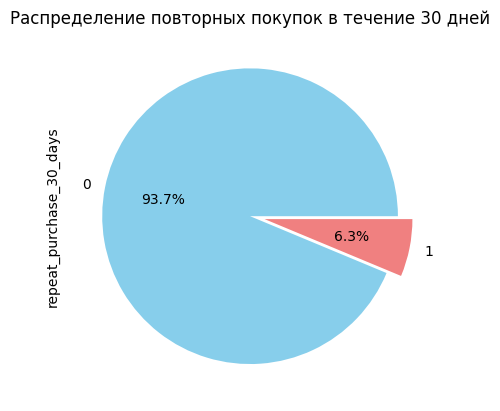

In [22]:
plt.figure()
apparel_total_df['repeat_purchase_30_days'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], explode=(0, 0.1)
)
plt.title('Распределение повторных покупок в течение 30 дней')
plt.show()

Доля повторных покупок составляет всего 6,3% от общего числа покупок. Единичные покупки преобладают в  15 раз по сравнению с повторными покупками.

In [23]:
# Находим последний месяц в данных
last_month = apparel_total_df['month'].max()

# Удаляем данные за последний месяц
apparel_total_df = apparel_total_df[apparel_total_df['month'] < last_month]

In [24]:
print("Минимальная дата:", apparel_total_df['date'].min())
print("Максимальная дата:", apparel_total_df['date'].max())

Минимальная дата: 2022-10-26 00:00:00
Максимальная дата: 2023-09-30 00:00:00


In [25]:
# Определение числа фолдов 
n_splits = 3 

# Создание объекта TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Разделение данных на тренировочные и тестовые 
for train_index, test_index in tscv.split(apparel_total_df):
    train_data, test_data = apparel_total_df.iloc[train_index], apparel_total_df.iloc[test_index]

target_column = 'repeat_purchase_30_days'

selected_features = ['quantity_total','price_total','orders_per_month','price_per_month',
                     'week_in_month','orders_per_week','price_per_week','is_holiday',
                     'unique_products_per_order','cumulative_unique_products','weekday',
                     'is_weekend','cumulative_weekend_orders'
]

# Переименование переменных
features_train, target_train = train_data[selected_features], train_data['repeat_purchase_30_days']
features_test, target_test = test_data[selected_features], test_data['repeat_purchase_30_days']

print("Размер тренировочной выборки:", features_train.shape)
print("Размер тестовой выборки:", features_test.shape)

Размер тренировочной выборки: (24402, 13)
Размер тестовой выборки: (8134, 13)


In [26]:
# Процентное соотношение классов для тренировочной выборки
train_class_distribution = target_train.value_counts(normalize=True) * 100

# Процентное соотношение классов для тестовой выборки
test_class_distribution = target_test.value_counts(normalize=True) * 100

print("Процентное соотношение классов в тренировочной выборке:")
print(train_class_distribution)

print("\nПроцентное соотношение классов в тестовой выборке:")
print(test_class_distribution)


Процентное соотношение классов в тренировочной выборке:
0    93.11122
1     6.88878
Name: repeat_purchase_30_days, dtype: float64

Процентное соотношение классов в тестовой выборке:
0    95.229899
1     4.770101
Name: repeat_purchase_30_days, dtype: float64


In [27]:
numerical_features = ['quantity_total', 'price_total', 'orders_per_month', 'price_per_month', 'orders_per_week','price_per_week', 'unique_products_per_order', 'cumulative_unique_products','cumulative_weekend_orders']

categorical_features = ['week_in_month', 'is_holiday', 'weekday',  'is_weekend']

In [28]:

catboost_params = {
    'cat_features': categorical_features,
    'depth': 6,
    'iterations': 1000,
    'learning_rate': 0.01,
    'auto_class_weights': 'Balanced',
    'verbose': 100,
    "early_stopping_rounds":50, 
    'random_state': 13112023,
    'loss_function': 'Logloss',  
    'eval_metric': 'AUC'  
}

cv_data = cv(
    Pool(features_train, label=target_train, cat_features=categorical_features),
    catboost_params,
    fold_count=n_splits,
    plot=False
)


Training on fold [0/3]
0:	test: 0.8268798	best: 0.8268798 (0)	total: 84.9ms	remaining: 1m 24s
100:	test: 0.8521861	best: 0.8534938 (69)	total: 4.39s	remaining: 39.1s

bestTest = 0.8534937753
bestIteration = 69

Training on fold [1/3]
0:	test: 0.8068168	best: 0.8068168 (0)	total: 56.3ms	remaining: 56.3s


100:	test: 0.8334656	best: 0.8335939 (99)	total: 3.96s	remaining: 35.2s
200:	test: 0.8381490	best: 0.8381490 (200)	total: 6.58s	remaining: 26.1s
300:	test: 0.8417473	best: 0.8418258 (299)	total: 8.9s	remaining: 20.7s
400:	test: 0.8446842	best: 0.8446842 (400)	total: 11.4s	remaining: 17s
500:	test: 0.8459973	best: 0.8459973 (500)	total: 13.3s	remaining: 13.3s
600:	test: 0.8475130	best: 0.8475130 (600)	total: 15.1s	remaining: 10s
700:	test: 0.8483877	best: 0.8483903 (699)	total: 16.7s	remaining: 7.11s
800:	test: 0.8493133	best: 0.8493195 (799)	total: 18.3s	remaining: 4.54s
900:	test: 0.8500516	best: 0.8500516 (900)	total: 19.9s	remaining: 2.19s
999:	test: 0.8517937	best: 0.8517937 (999)	total: 22.1s	remaining: 0us

bestTest = 0.8517937304
bestIteration = 999

Training on fold [2/3]
0:	test: 0.8199198	best: 0.8199198 (0)	total: 17.3ms	remaining: 17.3s
100:	test: 0.8459175	best: 0.8459175 (100)	total: 1.77s	remaining: 15.8s

bestTest = 0.8466450359
bestIteration = 144



In [29]:
# Обучение модели
final_model = CatBoostClassifier(**catboost_params)
final_model.fit(features_train, target_train, eval_set=(features_test, target_test))

# Предсказание вероятностей для тестового набора данных
predictions_proba_test = final_model.predict_proba(features_test)[:, 1]

# Расчет ROC-AUC на тестовом наборе данных
roc_auc_test = roc_auc_score(target_test, predictions_proba_test)

print("ROC-AUC на тестовом наборе данных:", roc_auc_test)

0:	test: 0.8126501	best: 0.8126501 (0)	total: 32.4ms	remaining: 32.3s
100:	test: 0.8179300	best: 0.8179300 (100)	total: 2.7s	remaining: 24s
200:	test: 0.8206996	best: 0.8207362 (193)	total: 5.11s	remaining: 20.3s
300:	test: 0.8214032	best: 0.8214438 (298)	total: 7.53s	remaining: 17.5s
400:	test: 0.8225389	best: 0.8225948 (399)	total: 9.89s	remaining: 14.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8227550435
bestIteration = 421

Shrink model to first 422 iterations.
ROC-AUC на тестовом наборе данных: 0.8227550435076568


In [30]:
predictions = final_model.predict(features_test)

accuracy = accuracy_score(target_test, predictions)
print(f"Accuracy на тестовой выборке: {accuracy:.4f}")

class_report = classification_report(target_test, predictions)
print("Отчет о классификации:")
print(class_report)

Accuracy на тестовой выборке: 0.9544
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      7746
           1       0.52      0.57      0.54       388

    accuracy                           0.95      8134
   macro avg       0.75      0.77      0.76      8134
weighted avg       0.96      0.95      0.96      8134



In [31]:
# Расчет ROC-AUC на тестовом наборе данных
roc_auc_test = roc_auc_score(target_test, predictions_proba_test)
print("ROC-AUC на тестовом наборе данных:", round(roc_auc_test, 4))

# Расчет F1-меры на тестовом наборе данных
f1_test = f1_score(target_test, predictions)
print("F1-мера на тестовой выборке:", round(f1_test, 4))

# Расчет точности на тестовом наборе данных
precision_test = precision_score(target_test, predictions)
print("Точность на тестовой выборке:", round(precision_test, 4))

# Расчет полноты на тестовом наборе данных
recall_test = recall_score(target_test, predictions)
print("Полнота на тестовой выборке:", round(recall_test, 4))

ROC-AUC на тестовом наборе данных: 0.8228
F1-мера на тестовой выборке: 0.5448
Точность на тестовой выборке: 0.5199
Полнота на тестовой выборке: 0.5722


Значение ROC-AUC  0.8228 говорит о хорошей способности модели различать между классами.

Значение F1-мера 0.5448 говорит о том, что модель хорошо сбалансирована между точностью и полнотой, но может быть улучшена.

Точность измеряет долю правильно предсказанных положительных классов от общего числа предсказанных положительных классов. Значение 0.5199 говорит о том, что модель имеет некоторые трудности с точностью предсказания положительных классов.

Полнота измеряет долю правильно предсказанных положительных классов от общего числа истинных положительных классов. Значение 0.5722 говорит о том, что модель хорошо выявляет истинные положительные классы, но также есть некоторые ложные отрицания.
В целом, модель демонстрирует неплохую способность к различению классов, но существует потенциал для улучшения в точности и полноте.

Confusion Matrix:
[[7541  205]
 [ 166  222]]


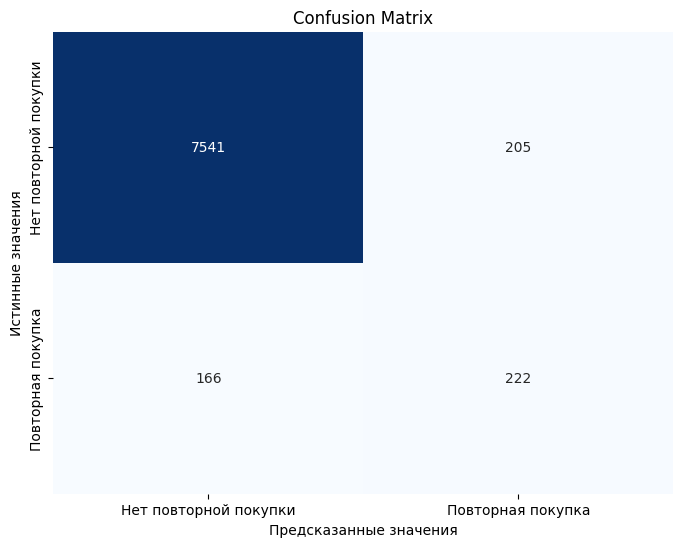

In [32]:
conf_matrix = confusion_matrix(target_test, predictions)

print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Нет повторной покупки', 'Повторная покупка'], 
            yticklabels=['Нет повторной покупки', 'Повторная покупка'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Confusion Matrix')
plt.show()

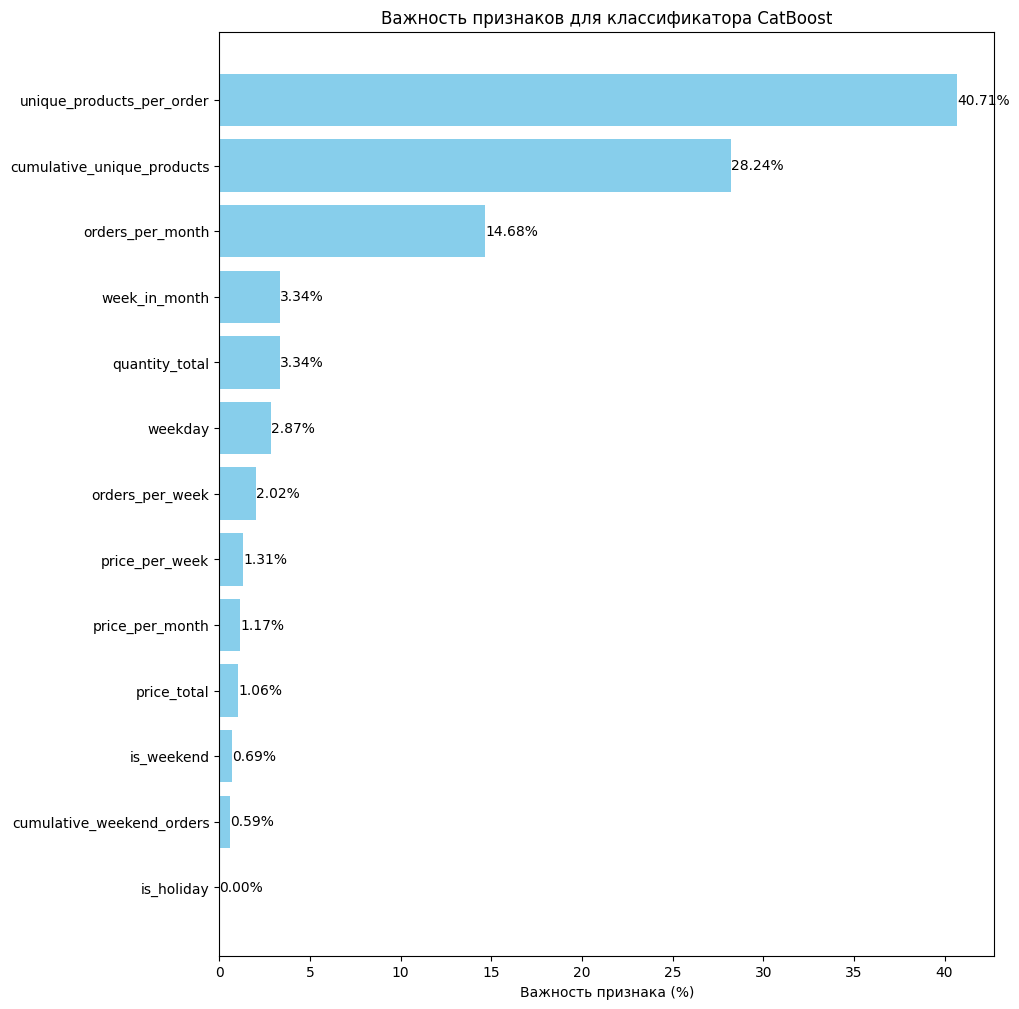

In [33]:
feature_importance = final_model.get_feature_importance()

# Имена признаков, использованные при обучении модели
feature_names = np.array(features_test.columns)

# Сортировка индексов признаков по важности в убывающем порядке
sorted_idx = np.argsort(feature_importance)[::-1]

# Вычисление процентного вклада каждого признака в общую важность
percent_importance = (feature_importance[sorted_idx] / np.sum(feature_importance)) * 100

# Создание горизонтальной столбчатой диаграммы
fig, ax = plt.subplots(figsize=(10, 12))
bars = ax.barh(range(len(sorted_idx)), percent_importance, align='center', color='skyblue')
ax.set_yticks(range(len(sorted_idx)))
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_xlabel('Важность признака (%)')
ax.set_title('Важность признаков для классификатора CatBoost')

# Добавление текста с процентами на столбцы
for i, bar in enumerate(bars):
    percentage = f'{percent_importance[i]:.2f}%'
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, percentage, 
            va='center', ha='left', fontsize=10, color='black')

plt.gca().invert_yaxis() 
plt.show()

Клиент, склонный к повторным покупкам: часто заказывает разнообразные товары в одном заказе, что указывает на интерес к широкому ассортименту продукции.Совершает покупки с высокой частотой  и тратит разнообразные суммы денег в течение месяца. Не только предпочитает покупки в будние дни, но также проявляет активность в выходные.

In [34]:
# Инициализация калиброванной модели с использованием сигмоидной калибровки
calibrated_model = CalibratedClassifierCV(final_model, method='sigmoid', cv='prefit')

# Обучение калиброванной модели на тестовом наборе данных
calibrated_model.fit(features_test, target_test)

# Предсказание калиброванных вероятностей для тестового набора данных
calibrated_predictions_proba_test = calibrated_model.predict_proba(features_test)[:, 1]

# Расчет ROC-AUC для калиброванных вероятностей на тестовом наборе данных
calibrated_roc_auc_test = roc_auc_score(target_test, calibrated_predictions_proba_test)

print("Калиброванный ROC-AUC на тестовом наборе данных:", calibrated_roc_auc_test)

Калиброванный ROC-AUC на тестовом наборе данных: 0.8227550435076568


Значение ROC-AUC 0.8228 говорит о том, что после калибровки модель сохраняет свою способность различать классы, и результаты остаются стабильными.

In [35]:
catboost_params = {
    'cat_features': categorical_features,
    'depth': 4,
    'iterations': 1500,
    'learning_rate': 0.05,
    'class_weights': [1, 9], 
    'verbose': 50,
    "early_stopping_rounds": 50, 
    'random_state': 13112023,
    'loss_function': 'Logloss',  
    'eval_metric': 'AUC',
}

# Обучение модели с измененными параметрами
final_model_updated = CatBoostClassifier(**catboost_params)
final_model_updated.fit(features_train, target_train, eval_set=(features_test, target_test), plot=False)

# Предсказание вероятностей для тестового набора данных
predictions_proba_test_updated = final_model_updated.predict_proba(features_test)[:, 1]

# Установка порога отнесения к классам
threshold = 0.4
predictions_updated = (predictions_proba_test_updated > threshold).astype(int)

# Расчет метрик
roc_auc_test_updated = roc_auc_score(target_test, predictions_proba_test_updated)
accuracy_updated = accuracy_score(target_test, predictions_updated)
f1_updated = f1_score(target_test, predictions_updated)
precision_updated = precision_score(target_test, predictions_updated)
recall_updated = recall_score(target_test, predictions_updated)

# Вывод результатов
print("Обновленные метрики:")
print(f"ROC-AUC на тестовом наборе данных: {roc_auc_test_updated:.4f}")
print(f"Accuracy на тестовой выборке: {accuracy_updated:.4f}")
print(f"F1-мера на тестовой выборке: {f1_updated:.4f}")
print(f"Точность на тестовой выборке: {precision_updated:.4f}")
print(f"Полнота на тестовой выборке: {recall_updated:.4f}")


0:	test: 0.7969910	best: 0.7969910 (0)	total: 32.2ms	remaining: 48.3s


50:	test: 0.8148955	best: 0.8167438 (46)	total: 1.3s	remaining: 36.8s
100:	test: 0.8215675	best: 0.8215675 (100)	total: 2.26s	remaining: 31.3s
150:	test: 0.8221345	best: 0.8226210 (144)	total: 3.36s	remaining: 30s
200:	test: 0.8230678	best: 0.8233257 (199)	total: 4.53s	remaining: 29.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8233256739
bestIteration = 199

Shrink model to first 200 iterations.
Обновленные метрики:
ROC-AUC на тестовом наборе данных: 0.8233
Accuracy на тестовой выборке: 0.9570
F1-мера на тестовой выборке: 0.5603
Точность на тестовой выборке: 0.5466
Полнота на тестовой выборке: 0.5747


Значение ROC-AUC  0.8228 говорит о хорошей способности модели различать между классами.

Значение F1-мера 0.5448 говорит о том, что модель хорошо сбалансирована между точностью и полнотой, но может быть улучшена.

Точность измеряет долю правильно предсказанных положительных классов от общего числа предсказанных положительных классов. Значение 0.5199 говорит о том, что модель имеет некоторые трудности с точностью предсказания положительных классов.

Полнота измеряет долю правильно предсказанных положительных классов от общего числа истинных положительных классов. Значение 0.5722 говорит о том, что модель хорошо выявляет истинные положительные классы, но также есть некоторые ложные отрицания.
В целом, модель демонстрирует неплохую способность к различению классов, но существует потенциал для улучшения в точности и полноте.

Изменения в параметрах модели привели к некоторому улучшению результатов. 

Значение ROC-AUC продолжает указывать на хорошую способность модели различать классы.

Значение F1-меры улучшилось, указывая на более сбалансированное предсказание классов.

Значение точности увеличилось, что говорит о снижении ложных положительных предсказаний.

Значение полноты также улучшилось, что свидетельствует о более высокой способности модели выявлять положительные классы.


In [36]:
# Создание дамми-модели
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(features_train, target_train)

# Предсказание на тестовых данных
dummy_predictions = dummy_model.predict(features_test)

# Вычисление метрик для дамми-модели
dummy_accuracy = accuracy_score(target_test, dummy_predictions)
dummy_roc_auc = roc_auc_score(target_test, dummy_model.predict_proba(features_test)[:, 1])
dummy_f1 = f1_score(target_test, dummy_predictions)
dummy_precision = precision_score(target_test, dummy_predictions, zero_division=1)
dummy_recall = recall_score(target_test, dummy_predictions)

print("Метрики для дамми-модели:")
print(f"Accuracy: {dummy_accuracy:.4f}")
print(f"ROC-AUC: {dummy_roc_auc:.4f}")
print(f"F1-мера: {dummy_f1:.4f}")
print(f"Точность: {dummy_precision:.4f}")
print(f"Полнота: {dummy_recall:.4f}")


Метрики для дамми-модели:
Accuracy: 0.9523
ROC-AUC: 0.5000
F1-мера: 0.0000
Точность: 1.0000
Полнота: 0.0000


**Полученные метрики для дамми-модели показывают следующее:**

Accuracy  0.95 Значение Accuracy довольно высокое, что может быть обусловлено дисбалансом классов в данных (1:9)

ROC-AUC 0.5000 - это площадь под ROC-кривой, которая характеризует способность модели различать между классами. Значение ROC-AUC для дамми-модели равно 0.5, что говорит о том, что она случайным образом предсказывает классы.

F1-мера 0.0000 - это гармоническое среднее точности и полноты. Значение F1-меры для дамми-модели равно 0, что говорит о том, что модель не способна ни правильно классифицировать положительные классы, ни минимизировать количество ложных срабатываний.

Использовался параметр zero_division=1,используемый для управления поведением функции, когда деление на ноль происходит в вычислении метрик. В данном случае, если деление на ноль произойдет при вычислении precision, то значение будет заменено на 1.

Метрики  Точность и Полнота для дамми-модели показывают 0. Точность оценивает долю правильно предсказанных положительных классов относительно всех предсказанных положительных случаев. В данном случае, модель не смогла распознать ни одного положительного случая. Отсутствие полноты указывает на то, что модель не смогла обнаружить ни одного положительного случая из всех действительно положительных. 

Сравнивая полученные метрики для дамми-модели с метриками основной модели, можно увидеть, что основная модель имеет лучшую производительность в сравнении с простой дамми-моделью, особенно учитывая значение F1-меры, точности и полноты. Стоит учесть, что ROC-AUC дамми-модели равен 0.5, что означает случайное угадывание классов.

## Изучим предоставленные данные  в магазине подарков.

In [37]:
gifts_df = pd.read_csv('data/gifts-purchases.csv')

In [38]:
gifts_df.head()

,client_id,quantity,price,date,message_id,recommended_by
0,1515915625803894158,1,8943.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
1,1515915625803894158,1,46369.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
2,1515915625803894158,1,4666.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
3,1515915625803894158,1,11963.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
4,1515915625803894158,1,13107.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message


In [39]:
gifts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       811 non-null    int64  
 1   quantity        811 non-null    int64  
 2   price           811 non-null    float64
 3   date            811 non-null    object 
 4   message_id      811 non-null    object 
 5   recommended_by  811 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 38.1+ KB


Столбцы recommended_by и message_id содержат значение bulk_message и идентификатор сообщения из рассылки,это признаки,которые не влияют на целевую переменную,не предоставляют полезной информации, их удаление улучшит производительность модели и упростит анализ данных.

In [40]:
gifts_df = gifts_df.drop(columns=['recommended_by','message_id'])

In [41]:
gifts_df['date'] = pd.to_datetime(gifts_df['date'])

print("Минимальная дата:", gifts_df['date'].min())
print("Максимальная дата:", gifts_df['date'].max())

Минимальная дата: 2022-10-26 00:00:00
Максимальная дата: 2023-10-24 00:00:00


В датафрейме данные о покупках представлены ровно за один календарный год.

In [42]:
# Упорядочиваем датасет по дате и клиенту
gifts_df_sorted = gifts_df.sort_values(by=['date', 'client_id'])

# Группируем по клиенту и дате, суммируем количество и сумму цен
gifts_total_df = gifts_df_sorted.groupby(['date', 'client_id']).agg({
    'quantity': 'sum',
    'price': 'sum'
}).reset_index()

gifts_total_df = gifts_total_df.rename(columns={'quantity': 'quantity_total', 'price': 'price_total'})

# Убеждаемся, что новый датафрейм создан корректно
gifts_total_df.head()

,date,client_id,quantity_total,price_total
0,2022-10-26,1515915625857065470,5,174768.0
1,2022-10-28,1515915625842031428,3,4821.0
2,2022-11-02,1515915625805906601,1,5236.0
3,2022-11-02,1515915625835005143,4,70200.0
4,2022-11-03,1515915625835005077,8,29016.0


### Cоздадим временные признаки, нарастающим итогом для обучения модели

Добавим новые столбцы: month, в котором для каждой даты указывается соответствующий месяц и столбцы,в которых указано кумулятивное количество заказов и цены для каждого клиента на каждый месяц.

In [43]:
gifts_total_df['month'] = gifts_total_df['date'].dt.to_period('M')

# Создаем кумулятивные суммы для количества заказов по месяцам
gifts_total_df['orders_per_month'] = gifts_total_df.groupby(['client_id', 'month']).cumcount() + 1

In [44]:
# Создаем кумулятивные суммы для суммы заказов по месяцам
gifts_total_df['price_per_month'] = (gifts_total_df.groupby(['client_id', 'month'])['price_total'].cumsum())

Добавим новый столбец orders_per_week, отражающий кумулятивное количество заказов и цены для каждого клиента по неделям, с указанием номера недели в месяце.

In [45]:
gifts_total_df['week_in_month'] = (gifts_total_df['date'].dt.day // 7 + 1)

# Создаем кумулятивные суммы для количества заказов по неделям
gifts_total_df['orders_per_week'] = (
    gifts_total_df.groupby(['client_id', 'month', 'week_in_month'])
    .cumcount() + 1
)

In [46]:
# Создаем кумулятивные суммы для суммы заказов по неделям
gifts_total_df['price_per_week'] = (
    gifts_total_df.groupby(['client_id', 'month', 'week_in_month'])['price_total']
    .cumsum()
)

In [47]:
# Добавление столбца "is_holiday" в датафрейм
gifts_total_df['is_holiday'] = np.where(gifts_total_df['date'].isin(russian_holidays), 1, 0)

Количество уникальных товаров в заказе

In [48]:
gifts_total_df['unique_products_per_order'] = gifts_total_df.groupby(['client_id', 'month'])['quantity_total'].transform('nunique')
gifts_total_df['cumulative_unique_products'] = gifts_total_df.groupby(['client_id', 'month'])['unique_products_per_order'].cumsum()

Доля заказов в выходные и будние дни

In [49]:
gifts_total_df['weekday'] = gifts_total_df['date'].dt.weekday
gifts_total_df['is_weekend'] = (gifts_total_df['weekday'] >= 5).astype(int)
gifts_total_df['cumulative_weekend_orders'] = gifts_total_df.groupby(['client_id', 'month'])['is_weekend'].cumsum()

In [50]:
gifts_total_df.head()

,date,client_id,quantity_total,price_total,month,orders_per_month,price_per_month,week_in_month,orders_per_week,price_per_week,is_holiday,unique_products_per_order,cumulative_unique_products,weekday,is_weekend,cumulative_weekend_orders
0,2022-10-26,1515915625857065470,5,174768.0,2022-10,1,174768.0,4,1,174768.0,0,1,1,2,0,0
1,2022-10-28,1515915625842031428,3,4821.0,2022-10,1,4821.0,5,1,4821.0,0,1,1,4,0,0
2,2022-11-02,1515915625805906601,1,5236.0,2022-11,1,5236.0,1,1,5236.0,0,1,1,2,0,0
3,2022-11-02,1515915625835005143,4,70200.0,2022-11,1,70200.0,1,1,70200.0,0,1,1,2,0,0
4,2022-11-03,1515915625835005077,8,29016.0,2022-11,1,29016.0,1,1,29016.0,0,1,1,3,0,0


In [51]:
# Создаем столбец с датой следующей покупки
gifts_total_df['next_purchase_date'] = gifts_total_df.groupby('client_id')['date'].shift(-1)

# Рассчитываем разницу в днях между текущей датой и следующей покупкой
gifts_total_df['days_next_purchase'] = (gifts_total_df['next_purchase_date'] - gifts_total_df['date']).dt.days

gifts_total_df['days_next_purchase'].fillna(999, inplace=True)

Если у клиента нет следующей даты покупки, это может означать, что он не совершил новой покупки в периоде, и в этом случае используем заглушку со значением 999, чтобы обозначить отсутствие следующей покупки. Это поможет сохранить данные для клиентов, у которых нет следующей покупки и в то же время создать целевую переменную для обучения модели.

### Создадим целевую переменную,проведем обучение, оптимизацию и тестирование модели

In [52]:
# Создаем целевую переменную
gifts_total_df['repeat_purchase_30_days'] = np.where(gifts_total_df['days_next_purchase'] <= 30, 1, 0)

In [53]:
print(gifts_total_df['repeat_purchase_30_days'].value_counts())

0    347
1     20
Name: repeat_purchase_30_days, dtype: int64


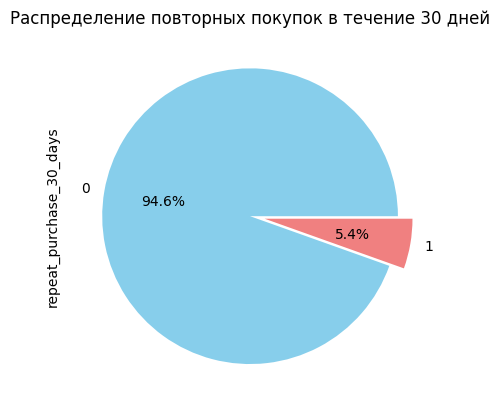

In [54]:
plt.figure()
gifts_total_df['repeat_purchase_30_days'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], explode=(0, 0.1)
)
plt.title('Распределение повторных покупок в течение 30 дней')
plt.show()

Единичные покупки преобладают в 17.5 раз по сравнению с повторными,однако у магазина есть потенциал для увеличения лояльности клиентов. Внедрение стратегий удержания и стимулирования повторных покупок может быть полезным для развития более постоянной клиентской базы.

In [55]:
# Находим последний месяц в данных
last_month = gifts_total_df['month'].max()

# Удаляем данные за последний месяц
gifts_total_df = gifts_total_df[gifts_total_df['month'] < last_month]

print("Минимальная дата:", gifts_total_df['date'].min())
print("Максимальная дата:", gifts_total_df['date'].max())

Минимальная дата: 2022-10-26 00:00:00
Максимальная дата: 2023-09-30 00:00:00


In [56]:
# Определение точки разделения по времени
split_time ='2023-06-15'

# Разделение данных на тренировочные и тестовые
train_data_gifts = gifts_total_df[gifts_total_df['date'] < split_time]
test_data_gifts = gifts_total_df[gifts_total_df['date'] >= split_time]

target_column_gifts = 'repeat_purchase_30_days'

selected_features_gifts = ['quantity_total', 'price_total', 'orders_per_month', 'price_per_month',
                     'week_in_month', 'orders_per_week', 'price_per_week', 'is_holiday',
                     'unique_products_per_order', 'cumulative_unique_products', 'weekday',
                     'is_weekend', 'cumulative_weekend_orders']

features_train_gifts, target_train_gifts = train_data_gifts[selected_features_gifts], train_data_gifts[target_column_gifts]
features_test_gifts, target_test_gifts = test_data_gifts[selected_features_gifts], test_data_gifts[target_column_gifts]

print("Размер тренировочной выборки:", features_train_gifts.shape)
print("Размер тестовой выборки:", features_test_gifts.shape)

Размер тренировочной выборки: (227, 13)
Размер тестовой выборки: (120, 13)


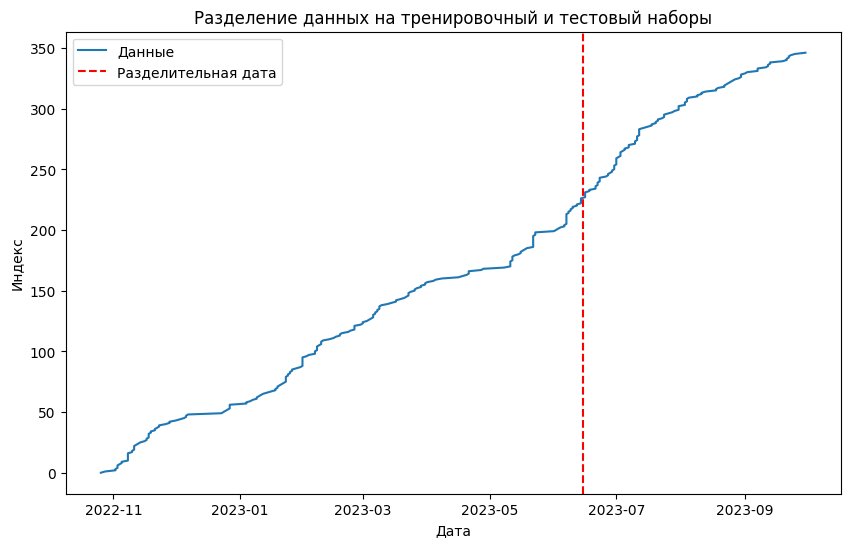

In [57]:
dates = gifts_total_df['date']

split_time = pd.to_datetime(split_time)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(dates, range(len(dates)), label='Данные')
plt.axvline(x=split_time, color='r', linestyle='--', label='Разделительная дата')
plt.title('Разделение данных на тренировочный и тестовый наборы')
plt.xlabel('Дата')
plt.ylabel('Индекс')
plt.legend()
plt.show()


In [58]:
# Процентное соотношение классов для тренировочной выборки
train_class_distribution_gifts = target_train_gifts.value_counts(normalize=True) * 100

# Процентное соотношение классов для тестовой выборки
test_class_distribution_gifts = target_test_gifts.value_counts(normalize=True) * 100

print("Процентное соотношение классов в тренировочной выборке:")
print(train_class_distribution_gifts)

print("\nПроцентное соотношение классов в тестовой выборке:")
print(test_class_distribution_gifts)

Процентное соотношение классов в тренировочной выборке:
0    94.273128
1     5.726872
Name: repeat_purchase_30_days, dtype: float64

Процентное соотношение классов в тестовой выборке:
0    94.166667
1     5.833333
Name: repeat_purchase_30_days, dtype: float64


In [59]:
numerical_features_gifts = ['quantity_total', 'price_total', 'orders_per_month', 'price_per_month',
                       'orders_per_week','price_per_week', 'unique_products_per_order', 
                       'cumulative_unique_products','cumulative_weekend_orders']

categorical_features_gifts = ['week_in_month', 'is_holiday', 'weekday',  'is_weekend']

In [60]:
catboost_params_gifts = {
    'cat_features': categorical_features_gifts,
    'depth': 6,
    'iterations': 1000,
    'learning_rate': 0.03,
    'auto_class_weights': 'Balanced',
    'verbose': 50,
    "early_stopping_rounds": 50, 
    'random_state': 13112023,
    'loss_function': 'Logloss',  
    'eval_metric': 'AUC',
}

# Обучение модели с измененными параметрами
final_model_gifts = CatBoostClassifier(**catboost_params_gifts)
final_model_gifts.fit(features_train_gifts, target_train_gifts, eval_set=(features_test_gifts, target_test_gifts), plot=False)

# Предсказание вероятностей для тестового набора данных
predictions_proba_test_gifts = final_model_gifts.predict_proba(features_test_gifts)[:, 1]

# Установка порога отнесения к классам
threshold_gifts = 0.5
predictions_gifts = (predictions_proba_test_gifts > threshold_gifts).astype(int)

# Расчет метрик
roc_auc_test_gifts = roc_auc_score(target_test_gifts, predictions_gifts)
accuracy_gifts = accuracy_score(target_test_gifts, predictions_gifts)
f1_gifts = f1_score(target_test_gifts, predictions_gifts)
precision_gifts = precision_score(target_test_gifts, predictions_gifts)
recall_gifts = recall_score(target_test_gifts, predictions_gifts)

# Вывод результатов
print(f"ROC-AUC на тестовом наборе данных: {roc_auc_test_gifts:.4f}")
print(f"Accuracy на тестовой выборке: {accuracy_gifts:.4f}")
print(f"F1-мера на тестовой выборке: {f1_gifts:.4f}")
print(f"Точность на тестовой выборке: {precision_gifts:.4f}")
print(f"Полнота на тестовой выборке: {recall_gifts:.4f}")

0:	test: 0.8305942	best: 0.8305942 (0)	total: 2.94ms	remaining: 2.93s
50:	test: 0.7762326	best: 0.8659924 (2)	total: 115ms	remaining: 2.13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8659924147
bestIteration = 2

Shrink model to first 3 iterations.
ROC-AUC на тестовом наборе данных: 0.8306
Accuracy на тестовой выборке: 0.9333
F1-мера на тестовой выборке: 0.5556
Точность на тестовой выборке: 0.4545
Полнота на тестовой выборке: 0.7143


ROC-AUC на тестовом наборе данных составляет 0.8306, что указывает на хорошую способность модели различать между классами.
F1-мера на тестовой выборке составляет 0.5556, что указывает на сбалансированность между точностью и полнотой.
Точность (Precision) на тестовой выборке равна 0.4545, что представляет собой долю правильно предсказанных положительных классов от общего числа предсказанных положительных классов.
Полнота (Recall) на тестовой выборке составляет 0.7143, что представляет собой долю правильно предсказанных положительных классов от общего числа истинных положительных классов.

Confusion Matrix:
[[107   6]
 [  2   5]]


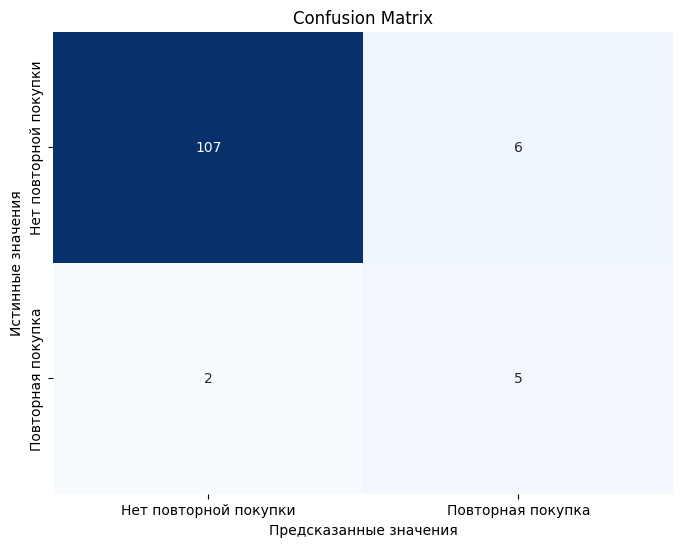

In [61]:
conf_matrix_gifts = confusion_matrix(target_test_gifts, predictions_gifts)

print("Confusion Matrix:")
print(conf_matrix_gifts)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gifts, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Нет повторной покупки', 'Повторная покупка'], 
            yticklabels=['Нет повторной покупки', 'Повторная покупка'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Confusion Matrix')
plt.show()

Верно предсказанных отрицательных (True Negatives, TN) случаев: 107
Ложно предсказанных положительных (False Positives, FP) случаев: 6
Ложно предсказанных отрицательных (False Negatives, FN) случаев: 2
Верно предсказанных положительных (True Positives, TP) случаев: 5

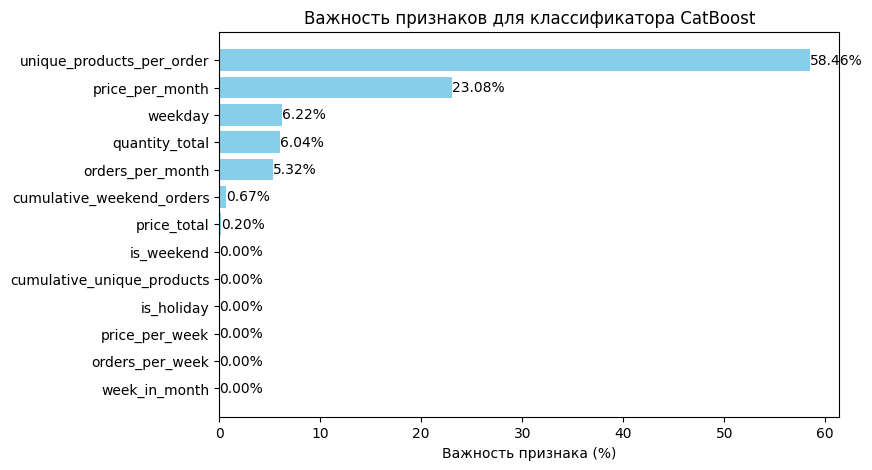

In [62]:
feature_importance_gifts = final_model_gifts.get_feature_importance()

# Имена признаков, использованные при обучении модели
feature_names_gifts = np.array(features_test_gifts.columns)

# Сортировка индексов признаков по важности в убывающем порядке
sorted_idx_gifts = np.argsort(feature_importance_gifts)[::-1]

# Вычисление процентного вклада каждого признака в общую важность
percent_importance_gifts = (feature_importance_gifts[sorted_idx_gifts] / np.sum(feature_importance_gifts)) * 100

# Создание горизонтальной столбчатой диаграммы
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(range(len(sorted_idx_gifts)), percent_importance_gifts, align='center', color='skyblue')
ax.set_yticks(range(len(sorted_idx_gifts)))
ax.set_yticklabels(feature_names_gifts[sorted_idx_gifts])
ax.set_xlabel('Важность признака (%)')
ax.set_title('Важность признаков для классификатора CatBoost')

# Добавление текста с процентами на столбцы
for i, bar in enumerate(bars):
    percentage_gifts = f'{percent_importance_gifts[i]:.2f}%'
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, percentage_gifts, 
            va='center', ha='left', fontsize=10, color='black')

plt.gca().invert_yaxis() 
plt.show()

Клиент, склонный к повторным покупкам, имеет характеристики, такие как предпочтение к разнообразным товарам,проявляет интерес к широкому ассортименту продукции,  высокие траты, определенные предпочтения в выборе дня для покупок, а также предпочтительность  к совершению покупок в будние дни.

In [63]:
# Инициализация калиброванной модели с использованием сигмоидной калибровки
calibrated_model_gifts = CalibratedClassifierCV(final_model_gifts, method='sigmoid', cv='prefit')

# Обучение калиброванной модели на тестовом наборе данных
calibrated_model_gifts.fit(features_test_gifts, target_test_gifts)

# Предсказание калиброванных вероятностей для тестового набора данных
calibrated_predictions_proba_test_gifts = calibrated_model_gifts.predict_proba(features_test_gifts)[:, 1]

# Расчет ROC-AUC для калиброванных вероятностей на тестовом наборе данных
calibrated_roc_auc_test_gifts = roc_auc_score(target_test_gifts, calibrated_predictions_proba_test_gifts)

print("Калиброванный ROC-AUC на тестовом наборе данных:", calibrated_roc_auc_test_gifts)

Калиброванный ROC-AUC на тестовом наборе данных: 0.8659924146649811


После калибровки вероятностей отнесения к классам значение ROC-AUC на тестовом наборе данных возрасло. Значение 0.8659 говорит о том, что модель обладает хорошей способностью различать между классами на тестовом наборе данных.

In [64]:
# Создание дамми-модели
dummy_model_gifts = DummyClassifier(strategy='most_frequent')
dummy_model_gifts.fit(features_train_gifts, target_train_gifts)

# Предсказание на тестовых данных
dummy_predictions_gifts = dummy_model_gifts.predict(features_test_gifts)

# Вычисление метрик для дамми-модели
dummy_accuracy_gifts = accuracy_score(target_test_gifts, dummy_predictions_gifts)
dummy_roc_auc_gifts = roc_auc_score(target_test_gifts, dummy_model_gifts.predict_proba(features_test_gifts)[:, 1])
dummy_f1_gifts = f1_score(target_test_gifts, dummy_predictions_gifts)
dummy_precision_gifts = precision_score(target_test_gifts, dummy_predictions_gifts, zero_division=1)
dummy_recall_gifts = recall_score(target_test_gifts, dummy_predictions_gifts)

print("Метрики для дамми-модели:")
print(f"Accuracy: {dummy_accuracy_gifts:.4f}")
print(f"ROC-AUC: {dummy_roc_auc_gifts:.4f}")
print(f"F1-мера: {dummy_f1_gifts:.4f}")
print(f"Точность: {dummy_precision_gifts:.4f}")
print(f"Полнота: {dummy_recall_gifts:.4f}")

Метрики для дамми-модели:
Accuracy: 0.9417
ROC-AUC: 0.5000
F1-мера: 0.0000
Точность: 1.0000
Полнота: 0.0000


Использовался параметр zero_division=1,используемый для управления поведением функции, когда деление на ноль происходит в вычислении метрик. В данном случае, если деление на ноль произойдет при вычислении precision, то значение будет заменено на 1.

Высокое значение Accuracy обусловлено доминированием одного из классов, что делает эту метрику непоказательной для задачи сильно несбалансированных классов.

ROC-AUC со значение 0.5 указывает на отсутствие различий между классами.

F1-мера  значение 0.0  указывает на то, что модель не способна ни правильно классифицировать положительные случаи, ни минимизировать ложные положительные случаи.

Точность значение 0.0 указывает на отсутствие правильных предсказаний положительных случаев.

Полнота значение 0.0 указывает на то, что модель не смогла выявить ни один фактический положительный случай.

Дамми-модель неэффективна и не обладает способностью предсказывать положительные случаи.

## Изучим предоставленные данные  в мультикатегорийном магазине с посещаемостью более 8 млн сессий в месяц.

In [65]:
marketplace_df = pd.read_csv('data/marketplace-purchases.csv')

In [66]:
marketplace_df.head()

,client_id,quantity,price,message_id,created_at,date
0,1515915625440944408,1,6298.0,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57
1,1515915625440992498,1,7318.0,1515915625440992498-1818-646b35d089c98,2023-05-22,2023-05-22 13:52:13
2,1515915625441026424,1,65798.0,1515915625441026424-1802-64634e24a2cb9,2023-05-17,2023-05-17 11:21:04
3,1515915625441118180,1,5598.0,1515915625441118180-1820-646c9444ebf39,2023-05-23,2023-05-23 19:02:53
4,1515915625441124500,1,77998.0,1515915625441124500-1825-646ed5cf4d5ed,2023-05-25,2023-05-25 07:46:52


Столбцы message_id содержит идентификатор сообщения из рассылки,created_at дату без указания времени - эти признаки,которые не влияют на целевую переменную,не предоставляют полезной информации, их удаление улучшит производительность модели и упростит анализ данных.

In [67]:
marketplace_df = marketplace_df.drop(columns=['created_at','message_id'])

In [68]:
marketplace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  48182 non-null  int64  
 1   quantity   48182 non-null  int64  
 2   price      48182 non-null  float64
 3   date       48182 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 1.5+ MB


In [69]:
marketplace_df['date'] = pd.to_datetime(marketplace_df['date'])

In [70]:
print("Минимальная дата:", marketplace_df['date'].min())
print("Максимальная дата:", marketplace_df['date'].max())

Минимальная дата: 2022-10-26 08:35:46
Максимальная дата: 2023-10-26 13:34:11


В датафрейме данные о покупках представлены ровно за один календарный год.

In [71]:
# Упорядочиваем датасет по дате и клиенту
marketplace_df_sorted = marketplace_df.sort_values(by=['date', 'client_id'])

# Группируем по клиенту и дате, суммируем количество и сумму цен
marketplace_total_df = marketplace_df_sorted.groupby(['date', 'client_id']).agg({
    'quantity': 'sum',
    'price': 'sum'
}).reset_index()

marketplace_total_df = marketplace_total_df.rename(columns={'quantity': 'quantity_total', 'price': 'price_total', 'message_id': 'most_common_message_id'})

# Убеждаемся, что новый датафрейм создан корректно
marketplace_total_df.head()

,date,client_id,quantity_total,price_total
0,2022-10-26 08:35:46,1515915625562386426,1,10598.0
1,2022-10-27 17:12:22,1515915625519806198,3,79596.0
2,2022-10-27 17:19:44,1515915625519806198,2,135396.0
3,2022-10-27 18:15:59,1515915625519806198,4,246993.0
4,2022-10-28 13:46:57,1515915625560501241,1,973.0


### Cоздадим временные признаки, нарастающим итогом для обучения модели

Добавим новые столбцы: month, в котором для каждой даты указывается соответствующий месяц и столбцы,в которых указано кумулятивное количество заказов и цены для каждого клиента на каждый месяц.

In [72]:
marketplace_total_df['month'] = marketplace_total_df['date'].dt.to_period('M')

# Создаем кумулятивные суммы для количества заказов по месяцам
marketplace_total_df['orders_per_month'] = marketplace_total_df.groupby(['client_id', 'month']).cumcount() + 1

In [73]:
# Создаем кумулятивные суммы для суммы заказов по месяцам
marketplace_total_df['price_per_month'] = (marketplace_total_df.groupby(['client_id', 'month'])['price_total'].cumsum())

Добавим новый столбец orders_per_week, отражающий кумулятивное количество заказов и цены для каждого клиента по неделям, с указанием номера недели в месяце.

In [74]:
marketplace_total_df['week_in_month'] = (marketplace_total_df['date'].dt.day // 7 + 1)

# Создаем кумулятивные суммы для количества заказов по неделям
marketplace_total_df['orders_per_week'] = (
    marketplace_total_df.groupby(['client_id', 'month', 'week_in_month'])
    .cumcount() + 1
)

In [75]:
# Создаем кумулятивные суммы для суммы заказов по неделям
marketplace_total_df['price_per_week'] = (
    marketplace_total_df.groupby(['client_id', 'month', 'week_in_month'])['price_total']
    .cumsum()
)

In [76]:
# Добавление столбца "is_holiday" в датафрейм
marketplace_total_df['is_holiday'] = np.where(marketplace_total_df['date'].isin(russian_holidays), 1, 0)

Разделим время покупки товаров на три интервала.Создадим столбец  'time_of_day' ,который будет содержать 0 для покупок в рабочее время(с 6:00 утра до 18:00 вечера), 1 для покупок в послерабочее время(с 18:00 вечера до полуночи) и 2 для ночного времени (с полуночи до 6:00 утра).

In [77]:
# Условие для рабочего времени (с 6:00 утра до 18:00 вечера)
workday_condition = (marketplace_total_df['date'].dt.hour >= 6) & (marketplace_total_df['date'].dt.hour < 18)

# Условие для послерабочего времени (с 18:00 вечера до полуночи)
evening_condition = (marketplace_total_df['date'].dt.hour >= 18) & (marketplace_total_df['date'].dt.hour < 24)

# Условие для ночного времени (с полуночи до 6:00 утра)
night_condition = (marketplace_total_df['date'].dt.hour >= 0) & (marketplace_total_df['date'].dt.hour < 6)

# Присвоение соответствующих значений 'time_of_day' в соответствии с условиями
marketplace_total_df.loc[workday_condition, 'time_of_day'] = 0 
marketplace_total_df.loc[evening_condition, 'time_of_day'] = 1  
marketplace_total_df.loc[night_condition, 'time_of_day'] = 2  

marketplace_total_df['time_of_day'] = marketplace_total_df['time_of_day'].astype(int)

Количество уникальных товаров в заказе

In [78]:
marketplace_total_df['unique_products_per_order'] = marketplace_total_df.groupby(['client_id', 'month'])['quantity_total'].transform('nunique')
marketplace_total_df['cumulative_unique_products'] = marketplace_total_df.groupby(['client_id', 'month'])['unique_products_per_order'].cumsum()

Доля заказов в выходные и будние дни

In [79]:
marketplace_total_df['weekday'] = marketplace_total_df['date'].dt.weekday
marketplace_total_df['is_weekend'] = (marketplace_total_df['weekday'] >= 5).astype(int)
marketplace_total_df['cumulative_weekend_orders'] = marketplace_total_df.groupby(['client_id', 'month'])['is_weekend'].cumsum()

In [80]:
# Преобразование столбца 'date' в формат без времени
marketplace_total_df['date'] = pd.to_datetime(marketplace_total_df['date'])
marketplace_total_df['date'] = marketplace_total_df['date'].dt.date
marketplace_total_df['date'] = pd.to_datetime(marketplace_total_df['date'])

# Создаем столбец с датой следующей покупки
marketplace_total_df['next_purchase_date'] = marketplace_total_df.groupby('client_id')['date'].shift(-1)

# Рассчитываем разницу в днях между текущей датой и следующей покупкой
marketplace_total_df['days_next_purchase'] = (marketplace_total_df['next_purchase_date'] - marketplace_total_df['date']).dt.days

# Заполняем пропуски значением 999
marketplace_total_df['days_next_purchase'].fillna(999, inplace=True)


Если у клиента нет следующей даты покупки, это может означать, что он не совершил новой покупки в периоде, и в этом случае используем заглушку со значением 999, чтобы обозначить отсутствие следующей покупки. Это поможет сохранить данные для клиентов, у которых нет следующей покупки и в то же время создать целевую переменную для обучения модели.

### Создадим целевую переменную,проведем обучение, оптимизацию и тестирование модели

In [81]:
marketplace_total_df['repeat_purchase_30_days'] = np.where((marketplace_total_df['days_next_purchase'] <= 30) & (marketplace_total_df['days_next_purchase'] > 0), 1, 0)


In [82]:
print(marketplace_total_df[marketplace_total_df['repeat_purchase_30_days'] == 1][['days_next_purchase', 'next_purchase_date']])

       days_next_purchase next_purchase_date
18                   12.0         2022-11-11
37                   21.0         2022-11-21
48                    6.0         2022-11-06
72                   29.0         2022-11-30
75                    1.0         2022-11-02
...                   ...                ...
31766                 1.0         2023-10-24
31814                 1.0         2023-10-24
31815                 1.0         2023-10-24
31820                 1.0         2023-10-24
31909                 1.0         2023-10-25

[3864 rows x 2 columns]


In [83]:
print(marketplace_total_df['repeat_purchase_30_days'].value_counts())

0    28126
1     3864
Name: repeat_purchase_30_days, dtype: int64


In [84]:
# Находим последний месяц в данных
last_month = marketplace_total_df['month'].max()

# Удаляем данные за последний месяц
marketplace_total_df = marketplace_total_df[marketplace_total_df['month'] < last_month]

In [85]:
print("Минимальная дата:", marketplace_total_df['date'].min())
print("Максимальная дата:", marketplace_total_df['date'].max())

Минимальная дата: 2022-10-26 00:00:00
Максимальная дата: 2023-09-30 00:00:00


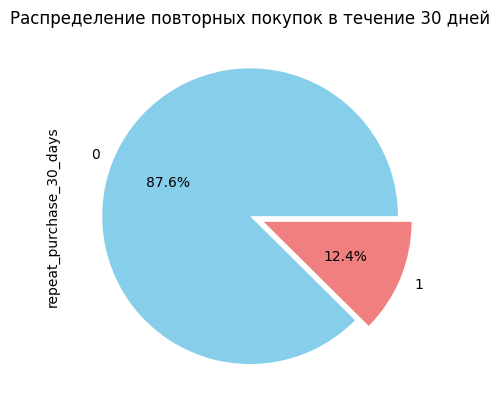

In [86]:
plt.figure()
marketplace_total_df['repeat_purchase_30_days'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], explode=(0, 0.1)
)
plt.title('Распределение повторных покупок в течение 30 дней')
plt.show()

Неповторные покупки преобладают в 7 раз. Однако присутствует небольшая, но значимая, доля клиентов (12,4%), которые совершают повторные покупки. Это указывает на наличие лояльной клиентской базы, готовой возвращаться для дополнительных покупок.

In [87]:
# Определение числа фолдов 
n_splits_marketplace = 3 

# Создание объекта TimeSeriesSplit
tscv_marketplace = TimeSeriesSplit(n_splits=n_splits_marketplace)

# Разделение данных на тренировочные и тестовые 
# Разделение данных на тренировочные и тестовые 
for train_index_marketplace, test_index_marketplace in tscv_marketplace.split(marketplace_total_df):
    train_data_marketplace, test_data_marketplace = marketplace_total_df.iloc[train_index_marketplace], marketplace_total_df.iloc[test_index_marketplace]

target_column_marketplace = 'repeat_purchase_30_days'

selected_features_marketplace = ['quantity_total','price_total','orders_per_month','price_per_month',
                     'week_in_month','orders_per_week','price_per_week','is_holiday', 'time_of_day',
                     'unique_products_per_order','cumulative_unique_products','weekday',
                     'is_weekend','cumulative_weekend_orders'
]

# Переименование переменных
features_train_marketplace, target_train_marketplace = train_data_marketplace[selected_features_marketplace], train_data_marketplace['repeat_purchase_30_days']
features_test_marketplace, target_test_marketplace = test_data_marketplace[selected_features_marketplace], test_data_marketplace['repeat_purchase_30_days']

print("Размер тренировочной выборки:", features_train_marketplace.shape)
print("Размер тестовой выборки:", features_test_marketplace.shape)

Размер тренировочной выборки: (22347, 14)
Размер тестовой выборки: (7448, 14)


In [88]:
# Процентное соотношение классов для тренировочной выборки
train_class_distribution_marketplace = target_train_marketplace.value_counts(normalize=True) * 100

# Процентное соотношение классов для тестовой выборки
test_class_distribution_marketplace = target_test_marketplace.value_counts(normalize=True) * 100

print("Процентное соотношение классов в тренировочной выборке:")
print(train_class_distribution_marketplace)

print("\nПроцентное соотношение классов в тестовой выборке:")
print(test_class_distribution_marketplace)

Процентное соотношение классов в тренировочной выборке:
0    88.114736
1    11.885264
Name: repeat_purchase_30_days, dtype: float64

Процентное соотношение классов в тестовой выборке:
0    85.929108
1    14.070892
Name: repeat_purchase_30_days, dtype: float64


In [89]:
numerical_features_marketplace = ['quantity_total', 'price_total', 'orders_per_month', 'price_per_month', 'orders_per_week','price_per_week', 'unique_products_per_order', 'cumulative_unique_products','cumulative_weekend_orders']

categorical_features_marketplace = ['week_in_month', 'is_holiday', 'weekday',  'is_weekend','time_of_day']

In [90]:
catboost_params_marketplace = {
    'cat_features': categorical_features_marketplace,
    'depth': 6,
    'iterations': 1500,
    'learning_rate': 0.001,
    'auto_class_weights': 'Balanced',
    'verbose': 100,
    "early_stopping_rounds":50, 
    'random_state': 13112023,
    'loss_function': 'Logloss',  
    'eval_metric': 'AUC'  
}

cv_data_marketplace = cv(
    Pool(features_train_marketplace, label=target_train_marketplace,
          cat_features=categorical_features_marketplace),
    catboost_params_marketplace,
    fold_count=n_splits_marketplace,
    plot=False
)


Training on fold [0/3]
0:	test: 0.6493845	best: 0.6493845 (0)	total: 22.4ms	remaining: 33.6s
100:	test: 0.7019673	best: 0.7025523 (95)	total: 4.2s	remaining: 58.1s

bestTest = 0.7025522619
bestIteration = 95

Training on fold [1/3]
0:	test: 0.6343571	best: 0.6343571 (0)	total: 23.4ms	remaining: 35.1s

bestTest = 0.6847307002
bestIteration = 8

Training on fold [2/3]
0:	test: 0.6378390	best: 0.6378390 (0)	total: 24.9ms	remaining: 37.4s
100:	test: 0.6840472	best: 0.6841111 (98)	total: 4.24s	remaining: 58.7s

bestTest = 0.6841110626
bestIteration = 98



In [91]:
# Обучение модели
final_model_marketplace = CatBoostClassifier(**catboost_params_marketplace)
final_model_marketplace.fit(features_train_marketplace, target_train_marketplace, eval_set=(features_test_marketplace, target_test_marketplace))

# Предсказание вероятностей для тестового набора данных
predictions_proba_test_marketplace = final_model_marketplace.predict_proba(features_test_marketplace)[:, 1]

# Расчет ROC-AUC на тестовом наборе данных
roc_auc_test_marketplace = roc_auc_score(target_test_marketplace, predictions_proba_test_marketplace)

print("ROC-AUC на тестовом наборе данных:", roc_auc_test_marketplace)
# Расчет ROC-AUC на тестовом наборе данных
roc_auc_test_marketplace = roc_auc_score(target_test_marketplace, predictions_proba_test_marketplace)
print("ROC-AUC на тестовом наборе данных:", round(roc_auc_test_marketplace, 2))

predictions_marketplace = final_model_marketplace.predict(features_test_marketplace)

# Расчет F1-меры на тестовом наборе данных
f1_test_marketplace = f1_score(target_test_marketplace, predictions_marketplace)
print("F1-мера на тестовой выборке:", round(f1_test_marketplace, 4))

# Расчет точности на тестовом наборе данных
precision_test_marketplace = precision_score(target_test_marketplace, predictions_marketplace)
print("Точность на тестовой выборке:", round(precision_test, 4))

# Расчет полноты на тестовом наборе данных
recall_test_marketplace = recall_score(target_test_marketplace, predictions_marketplace)
print("Полнота на тестовой выборке:", round(recall_test_marketplace, 4))

0:	test: 0.6597396	best: 0.6597396 (0)	total: 33ms	remaining: 49.5s


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7077978143
bestIteration = 5

Shrink model to first 6 iterations.
ROC-AUC на тестовом наборе данных: 0.7077978142891221
ROC-AUC на тестовом наборе данных: 0.71
F1-мера на тестовой выборке: 0.3601
Точность на тестовой выборке: 0.5199
Полнота на тестовой выборке: 0.52


ROC-AUC 0.71 говорит о том, что модель имеет неплохую способность различать между классами.

F1-мера значение 0.36 говорит о том, что у модели есть проблемы с балансом между точностью и полнотой.

Точность на тестовой выборке 0.5199 говорит о том, что примерно половина положительных предсказаний верны.

Полнота на тестовой выборке 0.52 говорит о том, что модель уловила примерно 52% всех положительных случаев.

Confusion Matrix:
[[4966 1434]
 [ 503  545]]


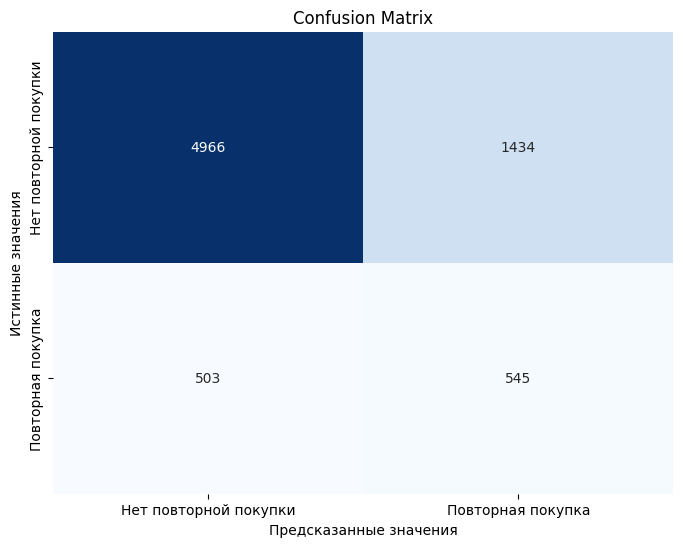

In [92]:
conf_matrix_marketplace = confusion_matrix(target_test_marketplace, predictions_marketplace)

print("Confusion Matrix:")
print(conf_matrix_marketplace)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_marketplace, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Нет повторной покупки', 'Повторная покупка'], 
            yticklabels=['Нет повторной покупки', 'Повторная покупка'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Confusion Matrix')
plt.show()

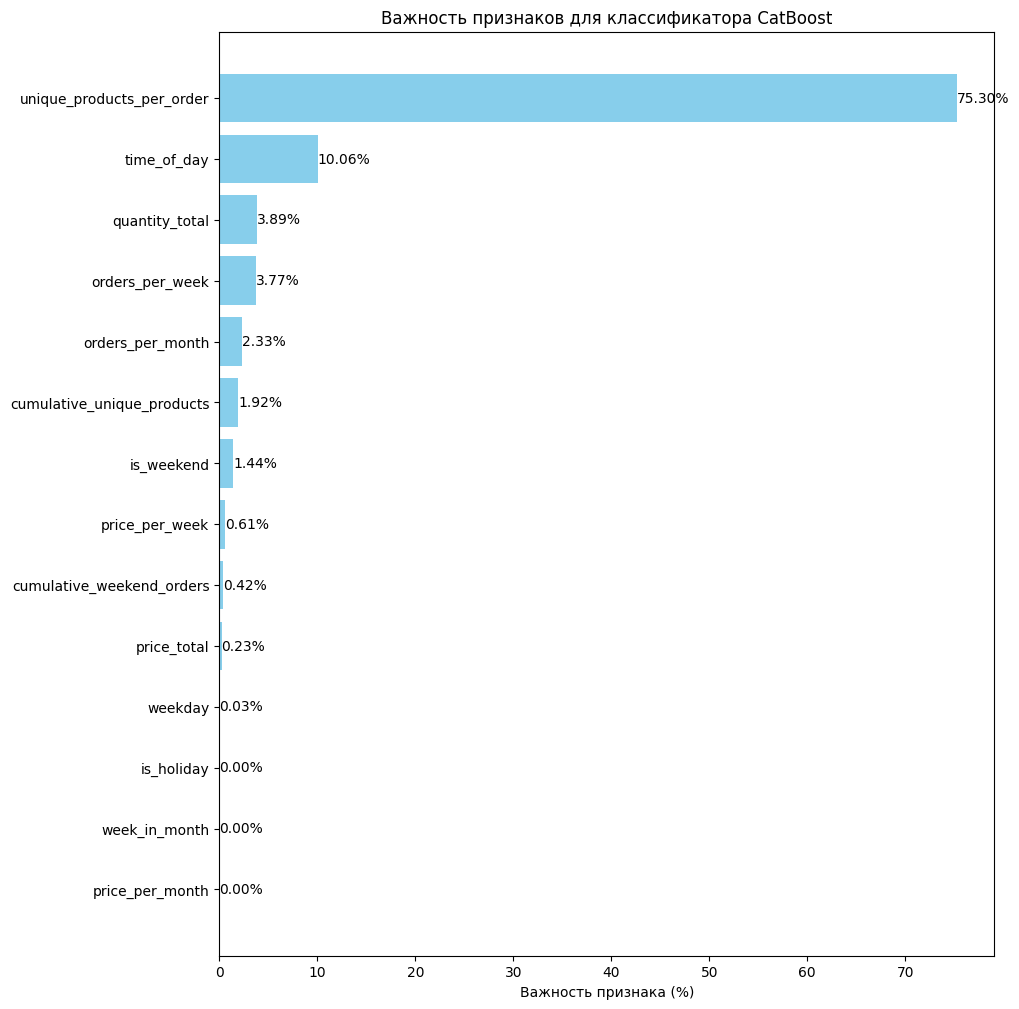

In [93]:
feature_importance_marketplace = final_model_marketplace.get_feature_importance()

# Имена признаков, использованные при обучении модели
feature_names_marketplace = np.array(features_test_marketplace.columns)

# Сортировка индексов признаков по важности в убывающем порядке
sorted_idx_marketplace = np.argsort(feature_importance_marketplace)[::-1]

# Вычисление процентного вклада каждого признака в общую важность
percent_importance_marketplace = (feature_importance_marketplace[sorted_idx_marketplace] / np.sum(feature_importance_marketplace)) * 100

# Создание горизонтальной столбчатой диаграммы
fig, ax = plt.subplots(figsize=(10, 12))
bars = ax.barh(range(len(sorted_idx_marketplace)), percent_importance_marketplace, align='center', color='skyblue')
ax.set_yticks(range(len(sorted_idx_marketplace)))
ax.set_yticklabels(feature_names_marketplace[sorted_idx_marketplace])
ax.set_xlabel('Важность признака (%)')
ax.set_title('Важность признаков для классификатора CatBoost')

# Добавление текста с процентами на столбцы
for i, bar in enumerate(bars):
    percentage_marketplace = f'{percent_importance_marketplace[i]:.2f}%'
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, percentage_marketplace, 
            va='center', ha='left', fontsize=10, color='black')

plt.gca().invert_yaxis() 
plt.show()

Клиент, склонный к повторным покупкам характеризуется заказами с разнообразными продуктами, предпочтением определенного времени для покупок, высоким общим расходом, регулярными заказами в течение недели или месяца, а также возможным предпочтением выходных дней для совершения покупок.

In [94]:
# Инициализация калиброванной модели с использованием сигмоидной калибровки
calibrated_model_marketplace = CalibratedClassifierCV(final_model_marketplace, method='sigmoid', cv='prefit')

# Обучение калиброванной модели на тестовом наборе данных
calibrated_model_marketplace.fit(features_test_marketplace, target_test_marketplace)

# Предсказание калиброванных вероятностей для тестового набора данных
calibrated_predictions_proba_test_marketplace = calibrated_model_marketplace.predict_proba(features_test_marketplace)[:, 1]

# Расчет ROC-AUC для калиброванных вероятностей на тестовом наборе данных
calibrated_roc_auc_test_marketplace = roc_auc_score(target_test_marketplace, calibrated_predictions_proba_test_marketplace)

print("Калиброванный ROC-AUC на тестовом наборе данных:", calibrated_roc_auc_test_marketplace)

Калиброванный ROC-AUC на тестовом наборе данных: 0.7077978142891221


Значение ROC-AUC 0.7089 говорит о том, что после калибровки модель сохраняет свою способность различать классы, и результаты остаются стабильными.

In [95]:
catboost_params_marketplace = {
    'cat_features': categorical_features_marketplace,
    'depth': 6,
    'iterations': 1500,
    'learning_rate': 0.05,
    'class_weights': [1, 9], 
    'verbose': 50,
    "early_stopping_rounds": 50, 
    'random_state': 13112023,
    'loss_function': 'Logloss',  
    'eval_metric': 'AUC',
}

# Обучение модели с измененными параметрами
final_model_updated_marketplace = CatBoostClassifier(**catboost_params_marketplace)
final_model_updated_marketplace.fit(features_train_marketplace, target_train_marketplace, eval_set=(features_test_marketplace, target_test_marketplace), plot=False)

# Предсказание вероятностей для тестового набора данных
predictions_proba_test_updated_marketplace = final_model_updated_marketplace.predict_proba(features_test_marketplace)[:, 1]

# Установка порога отнесения к классам
threshold_marketplace = 0.4
predictions_updated_marketplace = (predictions_proba_test_updated_marketplace > threshold_marketplace).astype(int)

# Расчет метрик
roc_auc_test_updated_marketplace = roc_auc_score(target_test_marketplace, predictions_proba_test_updated_marketplace)
accuracy_updated_marketplace = accuracy_score(target_test_marketplace, predictions_updated_marketplace)
f1_updated_marketplace = f1_score(target_test_marketplace, predictions_updated_marketplace)
precision_updated_marketplace = precision_score(target_test_marketplace, predictions_updated_marketplace)
recall_updated_marketplace = recall_score(target_test_marketplace, predictions_updated_marketplace)

# Вывод результатов
print("Обновленные метрики:")
print(f"ROC-AUC на тестовом наборе данных: {roc_auc_test_updated_marketplace:.4f}")
print(f"Accuracy на тестовой выборке: {accuracy_updated_marketplace:.4f}")
print(f"F1-мера на тестовой выборке: {f1_updated_marketplace:.4f}")
print(f"Точность на тестовой выборке: {precision_updated_marketplace:.4f}")
print(f"Полнота на тестовой выборке: {recall_updated_marketplace:.4f}")

0:	test: 0.6597396	best: 0.6597396 (0)	total: 27ms	remaining: 40.5s


50:	test: 0.7092609	best: 0.7092609 (50)	total: 1.43s	remaining: 40.5s
100:	test: 0.7113535	best: 0.7116331 (99)	total: 2.69s	remaining: 37.3s
150:	test: 0.7124535	best: 0.7124535 (150)	total: 4.34s	remaining: 38.8s
200:	test: 0.7119351	best: 0.7125201 (155)	total: 6.01s	remaining: 38.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7125201276
bestIteration = 155

Shrink model to first 156 iterations.
Обновленные метрики:
ROC-AUC на тестовом наборе данных: 0.7125
Accuracy на тестовой выборке: 0.3271
F1-мера на тестовой выборке: 0.2801
Точность на тестовой выборке: 0.1649
Полнота на тестовой выборке: 0.9303


После снижения порога отнесения к классам до 0.4 видны следующие обновленные метрики:

ROC-AUC не изменилось.

F1-мера также уменьшилась до 0.2801. Это связано с изменением баланса между точностью и полнотой после снижения порога.

Точность существенно уменьшилась, что говорит о том, что большинство предсказанных положительных случаев являются ложными положительными.

Полнота значительно выросла. Это означает, что модель теперь лучше улавливает истинные положительные случаи, но при этом она может допускать больше ложных положительных.

In [96]:
# Создание дамми-модели
dummy_model_marketplace = DummyClassifier(strategy='most_frequent')
dummy_model_marketplace.fit(features_train_marketplace, target_train_marketplace)

# Предсказание на тестовых данных
dummy_predictions_marketplace = dummy_model_marketplace.predict(features_test_marketplace)

# Вычисление метрик для дамми-модели
dummy_accuracy_marketplace = accuracy_score(target_test_marketplace, dummy_predictions_marketplace)
dummy_roc_auc_marketplace = roc_auc_score(target_test_marketplace, dummy_model_marketplace.predict_proba(features_test_marketplace)[:, 1])
dummy_f1_marketplace = f1_score(target_test_marketplace, dummy_predictions_marketplace)
dummy_precision_marketplace = precision_score(target_test_marketplace, dummy_predictions_marketplace, zero_division=1)
dummy_recall_marketplace = recall_score(target_test_marketplace, dummy_predictions_marketplace)

print("Метрики для дамми-модели:")
print(f"Accuracy: {dummy_accuracy_marketplace:.4f}")
print(f"ROC-AUC: {dummy_roc_auc_marketplace:.4f}")
print(f"F1-мера: {dummy_f1_marketplace:.4f}")
print(f"Точность: {dummy_precision_marketplace:.4f}")
print(f"Полнота: {dummy_recall_marketplace:.4f}")

Метрики для дамми-модели:
Accuracy: 0.8593
ROC-AUC: 0.5000
F1-мера: 0.0000
Точность: 1.0000
Полнота: 0.0000


*Полученные метрики для дамми-модели показывают следующее:**

Accuracy  0.86 Значение Accuracy довольно высокое, что может быть обусловлено дисбалансом классов в данных 

Значение ROC-AUC для дамми-модели равно 0.5, что говорит о том, что она случайным образом предсказывает классы.

Значение F1-меры для дамми-модели равно 0, что говорит о том, что модель не способна ни правильно классифицировать положительные классы, ни минимизировать количество ложных срабатываний.

Использовался параметр zero_division=1,используемый для управления поведением функции, когда деление на ноль происходит в вычислении метрик. В данном случае, если деление на ноль произойдет при вычислении precision, то значение будет заменено на 1.

Метрики  Точность и Полнота для дамми-модели показывают 0. Точность оценивает долю правильно предсказанных положительных классов относительно всех предсказанных положительных случаев. В данном случае, модель не смогла распознать ни одного положительного случая. Отсутствие полноты указывает на то, что модель не смогла обнаружить ни одного положительного случая из всех действительно положительных. 

Сравнивая полученные метрики для дамми-модели с метриками основной модели, можно увидеть, что основная модель имеет лучшую производительность в сравнении с простой дамми-моделью, особенно учитывая значение F1-меры, точности и полноты. Стоит учесть, что ROC-AUC дамми-модели равен 0.5, что означает случайное угадывание классов.

**<div style="text-align:center;">Итоговый вывод</div>**

По итогу проекта была успешно разработана модель для предсказания повторной покупки в течение 30 дней после заказа (временной ряд, классификация)

**Для apparel - магазин одежды, по характеристикам похожий на маркетплейс были достигнуты следующие результаты:**

- ROC-AUC на тестовом наборе данных: 0.8233
- F1-мера на тестовой выборке: 0.5603
- Точность на тестовой выборке: 0.5466
- Полнота на тестовой выборке: 0.5747

При изменении порога отнесения предсказаний к классу ROC-AUC  не меняется,однако возрастает F1-мера за счет увеличения точности.

**Для gifts – магазин подарков были достигнуты следующие результаты:**

- ROC-AUC на тестовом наборе данных: 0.8306
- F1-мера на тестовой выборке: 0.5556
- Точность на тестовой выборке: 0.4545
- Полнота на тестовой выборке: 0.7143

После калибровки (процесс коррекции вероятностных прогнозов, предоставляемых моделью, чтобы они были более точными и соответствовали реальным частотам наступления событий) ROC-AUC на тестовом наборе данных возрастает до 0.86

**Для marketplace - мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц были достигнуты следующие результаты:**

- ROC-AUC на тестовом наборе данных: 0.7125
- F1-мера на тестовой выборке: 0.3648
- Точность на тестовой выборке: 0.5199
- Полнота на тестовой выборке: 0.6345

При изменении порога отнесения предсказаний к классу ROC-AUC  не меняется,однако возрастает F1-мера,при этом уменьшается точность.

В целом модели демонстрируют хорошие показатели ROC-AUC, что свидетельствует о хорошей обобщающей способности.F1-мера варьируется в зависимости от порога отнесения предсказаний, что позволяет балансировать точность и полноту в соответствии с потребностями бизнеса.

### Проведем дополнительный анализ предоставленных данных

**✔ Цель:**

- Исследовать и выявить закономерности и изменения в потребительском поведении клиентов в преддверии праздничных событий.

Это позволит лучше понять, как изменяется спрос на товары в различные дни до праздников, а также выявить возможные пики покупок или изменения в покупательском поведении в это время.

Вернемся к данным о магазине одежды, по характеристикам похожий на маркетплейс

In [97]:
# Группировка по дате и агрегация данных
aggregated_data = apparel_total_df.groupby('date').agg({
    'client_id': 'count', 
    'quantity_total': 'sum',
    'price_total': 'sum',
    'is_holiday': 'max',  
}).reset_index()

# Добавление столбца 'days_until_holiday'
aggregated_data['days_until_holiday'] = 0

# Итерация по датафрейму для расчета 'days_until_holiday'
days_until_holiday = 0
for index, row in aggregated_data.iterrows():
    if row['is_holiday'] == 1:
        days_until_holiday = 0
    else:
        days_until_holiday += 1
    aggregated_data.at[index, 'days_until_holiday'] = days_until_holiday
# Вывести результаты
aggregated_data

,date,client_id,quantity_total,price_total,is_holiday,days_until_holiday
0,2022-10-26,7,13,37965.0,0,1
1,2022-10-27,6,21,16049.0,0,2
2,2022-10-28,9,20,17530.0,0,3
3,2022-10-29,8,11,19846.0,0,4
4,2022-10-30,10,24,27227.0,0,5
...,...,...,...,...,...,...
335,2023-09-26,15,69,85315.0,0,336
336,2023-09-27,87,409,830523.0,0,337
337,2023-09-28,24,85,77782.0,0,338
338,2023-09-29,24,137,94048.0,0,339


In [98]:
aggregated_data['days_until_holiday'].describe()

count    340.000000
mean     170.500000
std       98.293777
min        1.000000
25%       85.750000
50%      170.500000
75%      255.250000
max      340.000000
Name: days_until_holiday, dtype: float64

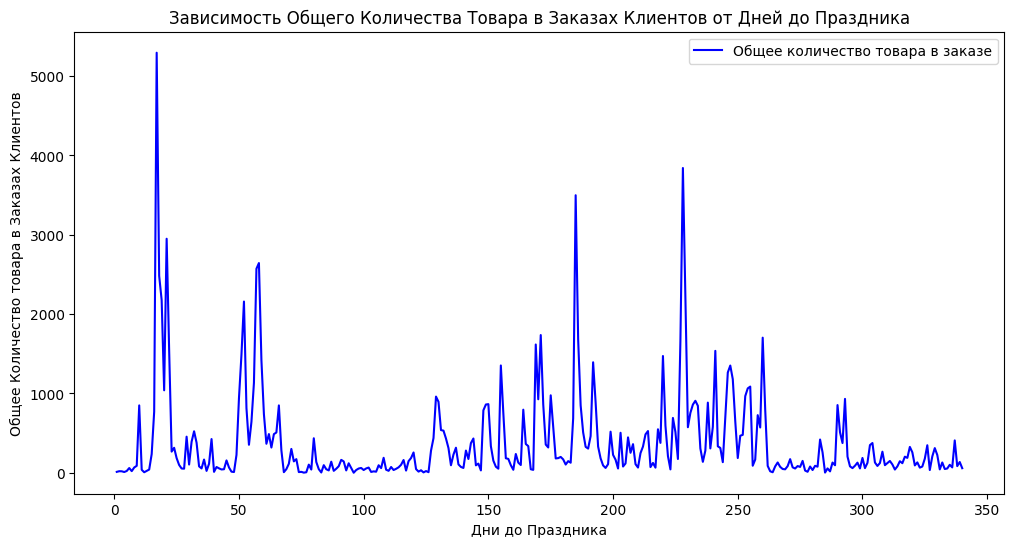

In [99]:
# Создание графика для зависимости метрики от дней до праздника
plt.figure(figsize=(12, 6))
sns.lineplot(x='days_until_holiday', y='quantity_total', data=aggregated_data, label='Общее количество товара в заказе', color='blue')
plt.title('Зависимость Общего Количества Товара в Заказах Клиентов от Дней до Праздника')
plt.xlabel('Дни до Праздника')
plt.ylabel('Общее Количество товара в Заказах Клиентов')
plt.legend()
plt.show()

Анализ данных за короткий период в один год ограничивает возможность выявления сезонных тенденций, однако позволяет выделить заметные пики в потребительском поведении клиентов. 

Основной пик покупок наблюдается за 15 дней до праздника, когда количество товаров достигает максимального значения. Этот пик свидетельствует о выраженной активности покупателей в этот период, вероятно, связанной с подготовкой к праздникам.

Наблюдаемые высокие значения за 225, 180 и 60 дней до праздника могут свидетельствовать о дополнительных факторах, влияющих на покупательское решение.

Важно отметить, что обнаруженные пики в покупательском поведении могут быть также подвержены внешним влияниям, таким как экономическая ситуация в стране. Несмотря на ограниченность временных данных, проведенный анализ позволяет лучше понять динамику покупок клиентов и выделить временные интервалы, требующие дополнительного внимания при планировании маркетинговых стратегий и управлении запасами товаров.

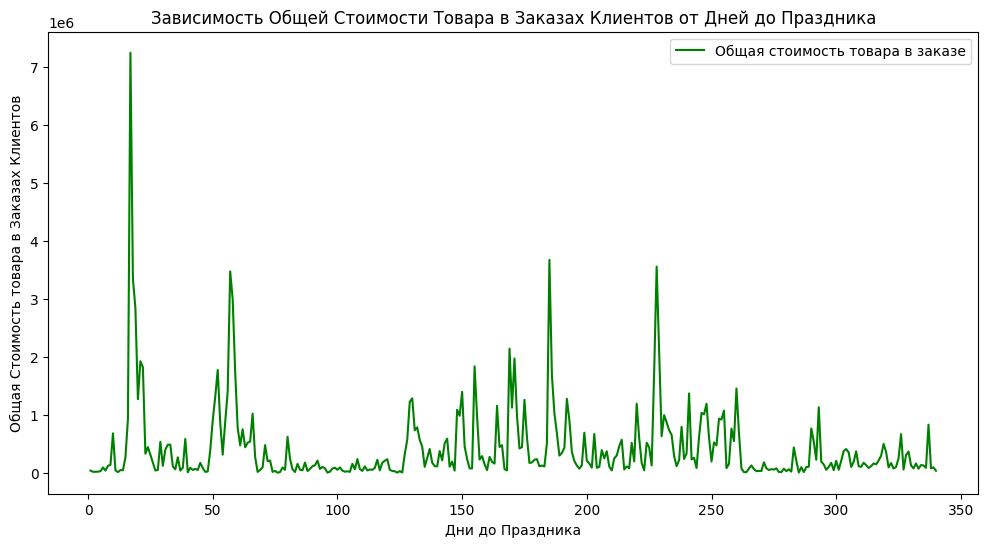

In [100]:
# Создание графика для зависимости метрики от дней до праздника
plt.figure(figsize=(12, 6))
sns.lineplot(x='days_until_holiday', y='price_total', data=aggregated_data, label='Общая стоимость товара в заказе', color='green')
plt.title('Зависимость Общей Стоимости Товара в Заказах Клиентов от Дней до Праздника')
plt.xlabel('Дни до Праздника')
plt.ylabel('Общая Стоимость товара в Заказах Клиентов')
plt.legend()
plt.show()

Анализ графика зависимости общей стоимости товара в заказах от дней до праздника подтверждает выявленные ранее закономерности в потребительском поведении. Наблюдаемые пики в стоимости заказов за 15, 225, 180 и 60 дней до праздника совпадают с пиками в количестве товаров, что подчеркивает устойчивость этих тенденций во времени.

Особенно выраженный пик за 15 дней до праздника с максимальной стоимостью заказов дополняет картину активной подготовки к праздникам, включая приобретение более дорогих товаров или увеличение объема покупок.

Эти результаты подчеркивают значимость учета временных факторов при планировании маркетинговых кампаний и стратегий управления запасами, что позволяет адаптировать подход к клиентам в зависимости от дней до предстоящих праздников.

**✔ Цель № 2:**

- Проанализировать как меняется покупательское поведение в разные дни недели и в выходные. 

Это может помочь определить оптимальные дни для проведения маркетинговых акций.

In [101]:
# Добавление столбца с днем недели (0 - понедельник, 1 - вторник, и так далее)
apparel_total_df['day_of_week'] = apparel_total_df['date'].dt.dayofweek

# Группировка данных по дню недели
day_of_week_data = apparel_total_df.groupby('day_of_week').agg({
    'quantity_total': 'sum',
    'price_total': 'sum',
    'orders_per_week': 'sum',
    # Другие интересующие вас метрики
}).reset_index()

# Маппинг для преобразования числовых значений дня недели в текстовый формат
day_mapping = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}
day_of_week_data['day_of_week'] = day_of_week_data['day_of_week'].map(day_mapping)

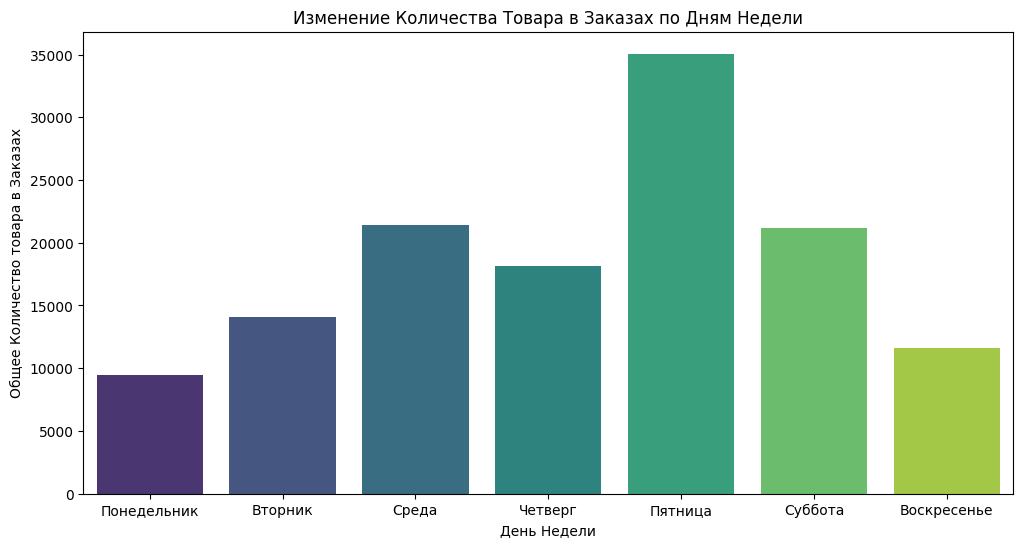

In [102]:
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='quantity_total', data=day_of_week_data, palette='viridis')
plt.title('Изменение Количества Товара в Заказах по Дням Недели')
plt.xlabel('День Недели')
plt.ylabel('Общее Количество товара в Заказах')
plt.show()

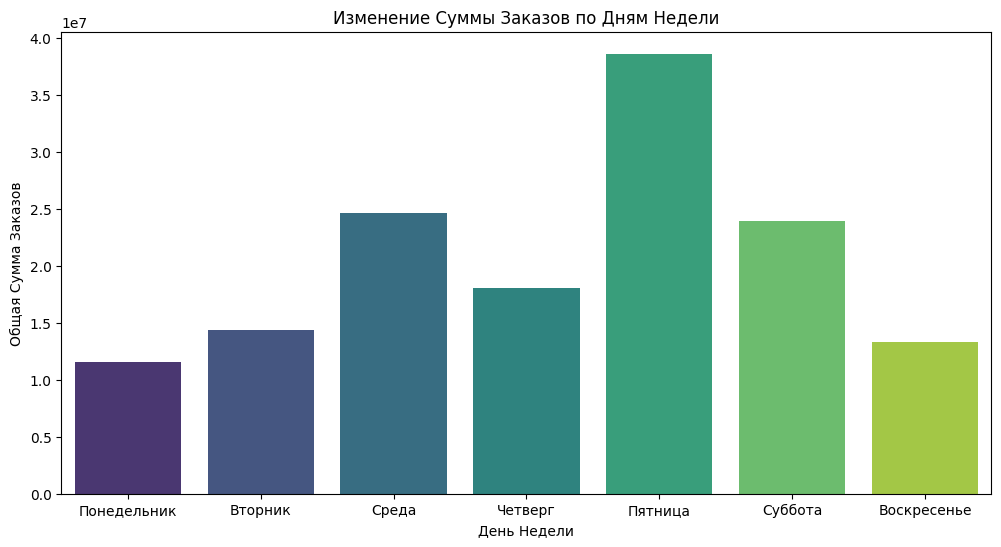

In [103]:
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='price_total', data=day_of_week_data, palette='viridis')
plt.title('Изменение Суммы Заказов по Дням Недели')
plt.xlabel('День Недели')
plt.ylabel('Общая Сумма Заказов')
plt.show()

Анализ распределения количества товаров и распределения сумм заказов по дням недели выявил следующие тренды:

1. Пятница является лидером по количеству товаров в заказах
2. Среда и суббота демонстрируют схожие показатели
3. Четверг следует за средой и субботой 
4. Вторник и воскресенье имеют более умеренные значения
5. Понедельник демонстрирует наименьшее количество товаров в заказах

Эти данные могут подсказывать о паттернах в покупательском поведении, что может быть полезно для определения оптимальных дней для проведения маркетинговых акций. Например, пятница, с ее высоким показателем, может быть привлекательным днем для акций или специальных предложений, в то время как в понедельник можно сосредоточить усилия на стимулировании покупок.

**✔ Цель № 3:**

- Анализ того, через сколько дней в среднем клиенты совершают следующую покупку.

Анализ времени между последовательными покупками позволяет определить средний период, через который клиенты совершают следующую покупку. В среднем клиенты проявляют активность и осуществляют следующую покупку через определенный промежуток времени, что может быть ключевым фактором для оптимизации стратегий удержания клиентов и планирования маркетинговых кампаний. Этот анализ предоставляет более глубокое понимание поведения клиентов и может служить основой для создания персонализированных стратегий взаимодействия с аудиторией.

In [104]:
# Группировка данных по значениям столбца days_next_purchase и вычисление среднего
average_days_next_purchase = apparel_total_df.groupby('days_next_purchase')['client_id'].count().mean()

# Вывод результата
print(f"В среднем клиенты совершают следующую покупку через {average_days_next_purchase:.2f} дней.")

В среднем клиенты совершают следующую покупку через 111.04 дней.


In [125]:
# Группировка данных по значениям столбца days_next_purchase и вычисление медианы
median_days_next_purchase = apparel_total_df.groupby('days_next_purchase')['client_id'].count().median()

# Вывод результата
print(f"В медиане клиенты совершают следующую покупку через {median_days_next_purchase:.2f} дней.")

В медиане клиенты совершают следующую покупку через 8.00 дней.


Среднее время до следующей покупки составляет 111 дней. Это значение может быть существенно подвержено влиянию выбросов или крайних значений,тк есть клиенты с очень длинным интервалом между покупками.
Медианное время до следующей покупки составляет 8 дней. Медиана устойчива к выбросам и представляет собой значение, разделяющее половину данных на меньшее и большее. Таким образом, 50% клиентов совершают следующую покупку в течение 8 дней или быстрее.

**✔ Цель № 4:**

- Анализ сегментации клиентов

Определение постоянных клиентов и новых клиентов позволяет лучше понять структуру клиентской базы и выявить ценные сегменты. Этот анализ направлен на выявление тенденций в поведении клиентов и может служить основой для принятия более таргетированных маркетинговых решений.

In [105]:
# Подсчет количества заказов для каждого клиента
order_count_per_client = apparel_total_df.groupby('client_id')['orders_per_month'].sum()

# Определение постоянных клиентов(топ 10%)
top_clients = order_count_per_client.sort_values(ascending=False).head(int(0.1 * len(order_count_per_client)))

# Определение новых клиентов (клиенты, у которых есть только один заказ)
new_clients = order_count_per_client[order_count_per_client == 1]

# Подсчет пропорции 'холодных'(новых) и постоянных клиентов
total_clients = len(order_count_per_client)
new_clients_proportion = len(new_clients) / total_clients
loyal_clients_proportion = 1 - new_clients_proportion

# Вывод результатов
print(f"Пропорция новых клиентов: {new_clients_proportion:.2%}")
print(f"Пропорция постоянных клиентов: {loyal_clients_proportion:.2%}")


Пропорция новых клиентов: 89.07%
Пропорция постоянных клиентов: 10.93%


Обнаруженный дисбаланс в пропорциях новых и постоянных клиентов (89.07% против 10.93%) подчеркивает важность проведения более детального анализа. Необходимо глубже изучить характеристики товаров, рейтинг и другие факторы, чтобы выявить возможные причины, по которым новые клиенты не переходят в категорию постоянных.

Анализ поведения клиентов, особенно их предпочтений в товарах, уровня удовлетворенности и опыта взаимодействия с сервисом, позволит выявить потенциальные области для улучшения. Это может включать в себя создание более персонализированных предложений, улучшение обслуживания клиентов или активное привлечение новых клиентов через маркетинговые кампании.

### Проведем дополнительный анализ предоставленных данных для магазина подарков

**✔ Цель №1:**

- Исследовать и выявить закономерности и изменения в потребительском поведении клиентов в преддверии праздничных событий.

Это позволит лучше понять, как изменяется спрос на товары в различные дни до праздников, а также выявить возможные пики покупок или изменения в покупательском поведении в это время.

In [106]:
# Группировка по дате и агрегация данных
aggregated_data_gifts = gifts_total_df.groupby('date').agg({
    'client_id': 'count', 
    'quantity_total': 'sum',
    'price_total': 'sum',
    'is_holiday': 'max',  
}).reset_index()

# Добавление столбца 'days_until_holiday'
aggregated_data_gifts['days_until_holiday'] = 0

# Итерация по датафрейму для расчета 'days_until_holiday'
days_until_holiday = 0
for index, row in aggregated_data_gifts.iterrows():
    if row['is_holiday'] == 1:
        days_until_holiday = 0
    else:
        days_until_holiday += 1
    aggregated_data_gifts.at[index, 'days_until_holiday'] = days_until_holiday

# Вывести результаты
aggregated_data_gifts

,date,client_id,quantity_total,price_total,is_holiday,days_until_holiday
0,2022-10-26,1,5,174768.0,0,1
1,2022-10-28,1,3,4821.0,0,2
2,2022-11-02,2,5,75436.0,0,3
3,2022-11-03,3,13,45814.0,0,4
4,2022-11-04,1,2,1658.0,0,5
...,...,...,...,...,...,...
174,2023-09-21,2,4,58020.0,0,175
175,2023-09-22,2,4,164067.0,0,176
176,2023-09-23,1,1,4495.0,0,177
177,2023-09-25,1,1,15571.0,0,178


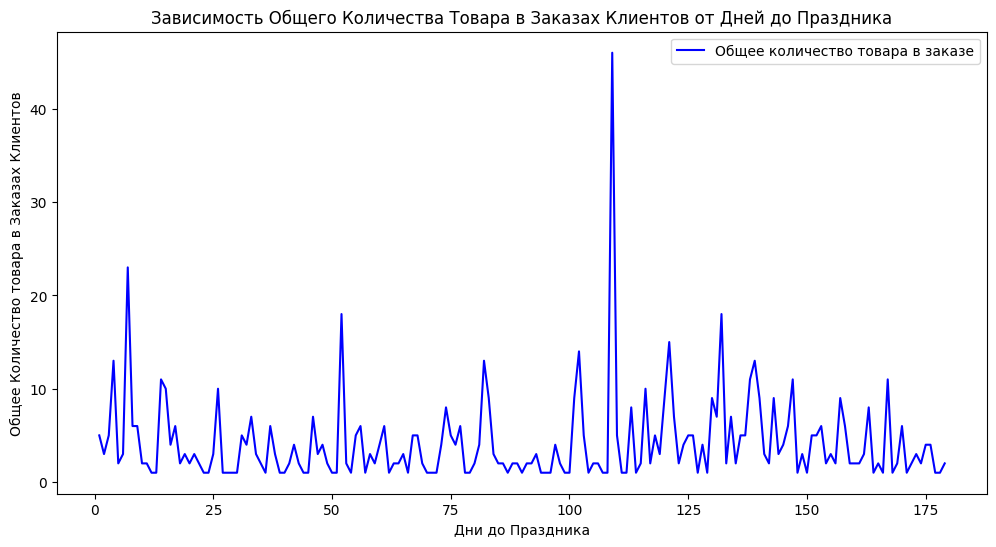

In [107]:
# Создание графика для зависимости метрики от дней до праздника
plt.figure(figsize=(12, 6))
sns.lineplot(x='days_until_holiday', y='quantity_total', data=aggregated_data_gifts, label='Общее количество товара в заказе', color='blue')
plt.title('Зависимость Общего Количества Товара в Заказах Клиентов от Дней до Праздника')
plt.xlabel('Дни до Праздника')
plt.ylabel('Общее Количество товара в Заказах Клиентов')
plt.legend()
plt.show()

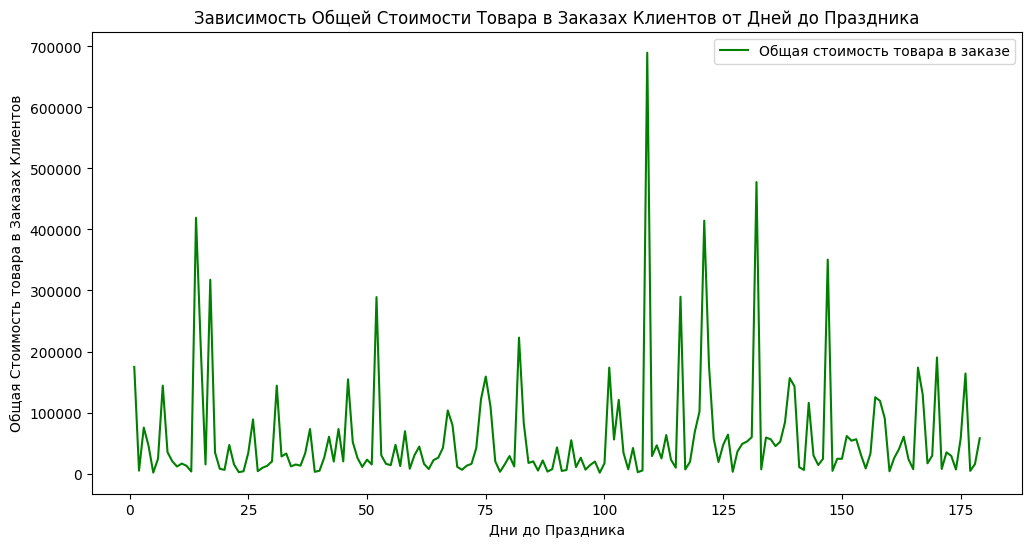

In [108]:
# Создание графика для зависимости метрики от дней до праздника
plt.figure(figsize=(12, 6))
sns.lineplot(x='days_until_holiday', y='price_total', data=aggregated_data_gifts, label='Общая стоимость товара в заказе', color='green')
plt.title('Зависимость Общей Стоимости Товара в Заказах Клиентов от Дней до Праздника')
plt.xlabel('Дни до Праздника')
plt.ylabel('Общая Стоимость товара в Заказах Клиентов')
plt.legend()
plt.show()

В ходе исследования потребительского поведения клиентов в преддверии праздничных событий для магазина подарков выявлены следующие закономерности. Наблюдается высокий пик покупок в 115 дней до праздника, что может быть связано с предварительными подготовками клиентов к праздничным событиям и поиском подходящих подарков. После этого периода, в 15 дней до праздника, отмечается второй значительный пик, который, вероятно, связан с более конкретным выбором подарков и финальными покупками.

Предполагаем, что первый пик свидетельствует о раннем интересе к праздничным покупкам, возможно, вызванным планированием и поиском уникальных или особенных подарков. Второй пик в 15 днях до праздника, скорее всего, отражает увеличенную активность в покупках, когда клиенты ближе к дате праздника принимают окончательные решения и осуществляют покупки.

Анализ данных за короткий период в один год ограничивает возможность выявления сезонных тенденций, однако позволяет выделить заметные пики в потребительском поведении клиентов. 

Важно отметить, что обнаруженные пики в покупательском поведении могут быть также подвержены внешним влияниям, таким как экономическая ситуация в стране. Несмотря на ограниченность временных данных, проведенный анализ позволяет лучше понять динамику покупок клиентов и выделить временные интервалы, требующие дополнительного внимания при планировании маркетинговых стратегий и управлении запасами товаров.

**✔ Цель № 2:**

- Проанализировать как меняется покупательское поведение в разные дни недели и в выходные. 

Это может помочь определить оптимальные дни для проведения маркетинговых акций.

In [109]:
# Добавление столбца с днем недели (0 - понедельник, 1 - вторник, и так далее)
gifts_total_df['day_of_week'] = gifts_total_df['date'].dt.dayofweek

# Группировка данных по дню недели
day_of_week_data_gifts = gifts_total_df.groupby('day_of_week').agg({
    'quantity_total': 'sum',
    'price_total': 'sum',
    'orders_per_week': 'sum',
    # Другие интересующие вас метрики
}).reset_index()

# Маппинг для преобразования числовых значений дня недели в текстовый формат
day_mapping_gifts = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}
day_of_week_data_gifts['day_of_week'] = day_of_week_data_gifts['day_of_week'].map(day_mapping_gifts)

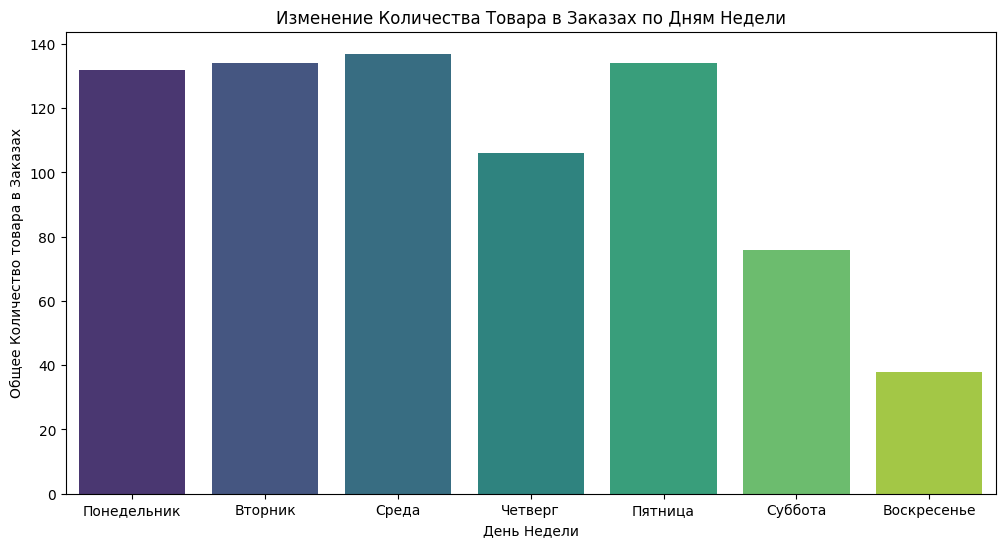

In [110]:
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='quantity_total', data=day_of_week_data_gifts, palette='viridis')
plt.title('Изменение Количества Товара в Заказах по Дням Недели')
plt.xlabel('День Недели')
plt.ylabel('Общее Количество товара в Заказах')
plt.show()

Анализ распределения количества товаров по дням недели выявил следующие тренды:

1. Среда и пятница являются лидером по количеству товаров в заказах
2. Вторник и понедельник демонстрируют схожие показатели
3. Четверг следует за вторником и понедельником
4. Суббота имеет более умеренное значение
5. Воскресенье демонстрирует наименьшее количество товаров в заказах

Эти данные могут подсказывать о паттернах в покупательском поведении, что может быть полезно для определения оптимальных дней для проведения маркетинговых акций. Например, пятница, с ее высоким показателем, может быть привлекательным днем для акций или специальных предложений, в то время как в понедельник можно сосредоточить усилия на стимулировании покупок.

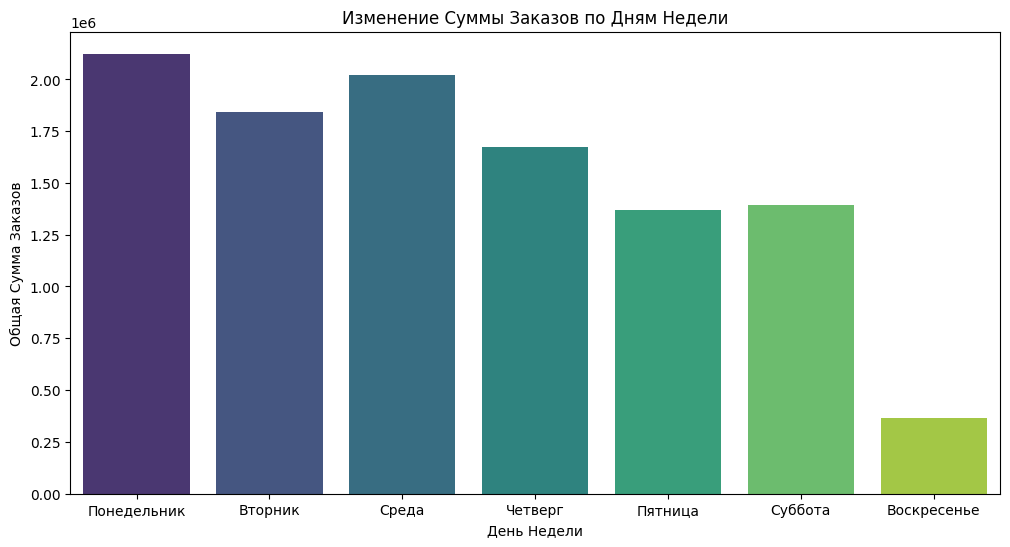

In [111]:
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='price_total', data=day_of_week_data_gifts, palette='viridis')
plt.title('Изменение Суммы Заказов по Дням Недели')
plt.xlabel('День Недели')
plt.ylabel('Общая Сумма Заказов')
plt.show()

Анализ распределения суммы заказов по дням недели немного отличается:

1. Понедельник и среда являются лидером по количеству товаров в заказах
2. Вторник и четверг демонстрируют схожие показатели
3. Пятница и суббота демонстрируют схожие показатели
4. Воскресенье демонстрирует наименьшее количество товаров в заказах

Эти данные могут подсказывать о паттернах в покупательском поведении, что может быть полезно для определения оптимальных дней для проведения маркетинговых акций. Например, пятница, с ее высоким показателем, может быть привлекательным днем для акций или специальных предложений, в то время как в понедельник можно сосредоточить усилия на стимулировании покупок.


**✔ Цель № 3:**

- Анализ того, через сколько дней в среднем клиенты совершают следующую покупку.

Анализ времени между последовательными покупками позволяет определить средний период, через который клиенты совершают следующую покупку. В среднем клиенты проявляют активность и осуществляют следующую покупку через определенный промежуток времени, что может быть ключевым фактором для оптимизации стратегий удержания клиентов и планирования маркетинговых кампаний. Этот анализ предоставляет более глубокое понимание поведения клиентов и может служить основой для создания персонализированных стратегий взаимодействия с аудиторией.

In [112]:
# Группировка данных по значениям столбца days_next_purchase и вычисление среднего
average_days_next_purchase_gifts = gifts_total_df.groupby('days_next_purchase')['client_id'].count().mean()

# Вывод результата
print(f"В среднем клиенты совершают следующую покупку через {average_days_next_purchase_gifts:.2f} дней.")

В среднем клиенты совершают следующую покупку через 10.84 дней.


In [128]:
# Группировка данных по значениям столбца days_next_purchase и вычисление медианы
median_days_next_purchase_gifts = gifts_total_df.groupby('days_next_purchase')['client_id'].count().median()

# Вывод результата
print(f"В медиане клиенты совершают следующую покупку через {median_days_next_purchase_gifts:.3f} дней.")

В медиане клиенты совершают следующую покупку через 1.000 дней.


Среднее время до следующей покупки составляет 10 дней. Однако следует учесть, что среднее чувствительно к выбросам, и большие значения в данных могут исказить результат.
Медианное время до следующей покупки составляет 1 день.  Медиана менее подвержена влиянию крайних значений.

In [129]:
# Расчет суммы покупок для каждого клиента
client_total_spending = gifts_total_df.groupby('client_id')['price_total'].sum().sort_values(ascending=False)

# Вывод рейтинга клиентов
print("Рейтинг клиентов по общей сумме покупок:")
print(client_total_spending)

# Количество клиентов, сделавших покупки на 20 тысяч и выше
high_spending_clients = client_total_spending[client_total_spending >= 20000]
low_spending_clients = client_total_spending[client_total_spending < 20000]

# Вывод количества клиентов на 20 тысяч и выше
print("\nКоличество клиентов с покупками на 20 тысяч и выше:", len(high_spending_clients))
print("Количество клиентов с покупками на менее чем 20 тысяч:", len(low_spending_clients))

Рейтинг клиентов по общей сумме покупок:
client_id
1515915625803892965    594503.0
1515915625803894158    563394.0
1515915625858800593    371125.0
1515915625855755713    360460.0
1515915625824280360    311984.0
                         ...   
1515915625803209237      1453.0
1515915625928280841       749.0
1515915625803275365       669.0
1515915625835006190       669.0
1515915625964487373       669.0
Name: price_total, Length: 309, dtype: float64

Количество клиентов с покупками на 20 тысяч и выше: 139
Количество клиентов с покупками на менее чем 20 тысяч: 170


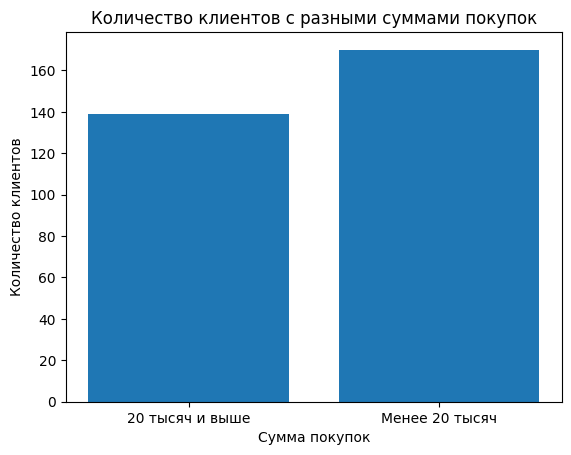

In [132]:
plt.bar(['20 тысяч и выше', 'Менее 20 тысяч'], [len(high_spending_clients), len(low_spending_clients)])

# Добавление подписей и заголовка
plt.xlabel('Сумма покупок')
plt.ylabel('Количество клиентов')
plt.title('Количество клиентов с разными суммами покупок')

# Отображение графика
plt.show()

In [131]:
# Расчет суммы покупок для каждого клиента
client_total_spending = gifts_total_df.groupby('client_id')['price_total'].sum().sort_values(ascending=False)

# Вывод топ-10 клиентов
top_10_clients = client_total_spending.head(10)
print("Топ-10 клиентов по общей сумме покупок:")
print(top_10_clients)

# Количество клиентов, сделавших покупки на 20 тысяч и выше
high_spending_clients = client_total_spending[client_total_spending >= 20000]
low_spending_clients = client_total_spending[client_total_spending < 20000]

# Вывод количества клиентов на 20 тысяч и выше
print("\nКоличество клиентов с покупками на 20 тысяч и выше:", len(high_spending_clients))
print("Количество клиентов с покупками на менее чем 20 тысяч:", len(low_spending_clients))

Топ-10 клиентов по общей сумме покупок:
client_id
1515915625803892965    594503.0
1515915625803894158    563394.0
1515915625858800593    371125.0
1515915625855755713    360460.0
1515915625824280360    311984.0
1515915625984601209    211681.0
1515915625857065470    174768.0
1515915625835000501    173586.0
1515915625949117112    164198.0
1515915625861627387    157289.0
Name: price_total, dtype: float64

Количество клиентов с покупками на 20 тысяч и выше: 139
Количество клиентов с покупками на менее чем 20 тысяч: 170


In [130]:
# Посмотреть количество уникальных клиентов в gifts_total_df
total_unique_clients = gifts_total_df['client_id'].nunique()

# Вывести результат
print("Всего клиентов в gifts_total_df:", total_unique_clients)

Всего клиентов в gifts_total_df: 309


**✔ Цель № 4:**

- Анализ сегментации клиентов

Определение постоянных клиентов и новых клиентов позволяет лучше понять структуру клиентской базы и выявить ценные сегменты. Этот анализ направлен на выявление тенденций в поведении клиентов и может служить основой для принятия более таргетированных маркетинговых решений.

In [113]:
# Подсчет количества заказов для каждого клиента
order_count_per_client_gifts = gifts_total_df.groupby('client_id')['orders_per_month'].sum()

# Определение постоянных клиентов(топ 10%)
top_clients_gifts = order_count_per_client_gifts.sort_values(ascending=False).head(int(0.1 * len(order_count_per_client_gifts)))

# Определение новых клиентов (клиенты, у которых есть только один заказ)
new_clients_gifts = order_count_per_client_gifts[order_count_per_client_gifts == 1]

# Подсчет пропорции 'холодных'(новых) и постоянных клиентов
total_clients_gifts = len(order_count_per_client_gifts)
new_clients_proportion_gifts = len(new_clients_gifts) / total_clients_gifts
loyal_clients_proportion_gifts = 1 - new_clients_proportion_gifts

# Вывод результатов
print(f"Пропорция новых клиентов: {new_clients_proportion_gifts:.2%}")
print(f"Пропорция постоянных клиентов: {loyal_clients_proportion_gifts:.2%}")


Пропорция новых клиентов: 90.61%
Пропорция постоянных клиентов: 9.39%


Обнаруженный дисбаланс в пропорциях новых и постоянных клиентов (90.61% против 9.39%) подчеркивает важность проведения более детального анализа. Необходимо глубже изучить характеристики товаров, рейтинг и другие факторы, чтобы выявить возможные причины, по которым новые клиенты не переходят в категорию постоянных.

Анализ поведения клиентов, особенно их предпочтений в товарах, уровня удовлетворенности и опыта взаимодействия с сервисом, позволит выявить потенциальные области для улучшения. Это может включать в себя создание более персонализированных предложений, улучшение обслуживания клиентов или активное привлечение новых клиентов через маркетинговые кампании.

### Проведем дополнительный анализ предоставленных данных для мультикатегорийного магазина с посещаемостью более 8 млн сессий в месяц

**✔ Цель:**

- Исследовать и выявить закономерности и изменения в потребительском поведении клиентов в преддверии праздничных событий.

Это позволит лучше понять, как изменяется спрос на товары в различные дни до праздников, а также выявить возможные пики покупок или изменения в покупательском поведении в это время.

In [114]:
# Группировка по дате и агрегация данных
aggregated_data_marketplace = marketplace_total_df.groupby('date').agg({
    'client_id': 'count', 
    'quantity_total': 'sum',
    'price_total': 'sum',
    'is_holiday': 'max',  
}).reset_index()

# Добавление столбца 'days_until_holiday'
aggregated_data_marketplace['days_until_holiday'] = 0

# Итерация по датафрейму для расчета 'days_until_holiday'
days_until_holiday_marketplace = 0
for index, row in aggregated_data_marketplace.iterrows():
    if row['is_holiday'] == 1:
        days_until_holiday_marketplace = 0
    else:
        days_until_holiday_marketplace += 1
    aggregated_data_marketplace.at[index, 'days_until_holiday'] = days_until_holiday_marketplace
# Вывести результаты
aggregated_data_marketplace

,date,client_id,quantity_total,price_total,is_holiday,days_until_holiday
0,2022-10-26,1,1,10598.0,0,1
1,2022-10-27,3,9,461985.0,0,2
2,2022-10-28,7,10,70078.0,0,3
3,2022-10-29,5,6,25133.0,0,4
4,2022-10-30,3,4,2064.0,0,5
...,...,...,...,...,...,...
334,2023-09-26,167,249,4029935.0,0,335
335,2023-09-27,248,347,7330908.0,0,336
336,2023-09-28,289,387,7023841.0,0,337
337,2023-09-29,242,415,5974464.0,0,338


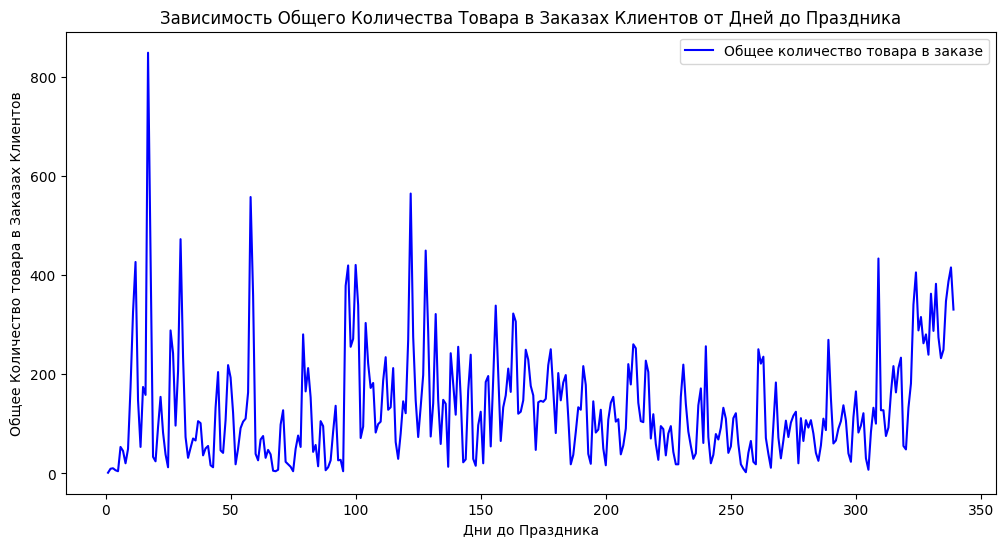

In [115]:
# Создание графика для зависимости метрики от дней до праздника
plt.figure(figsize=(12, 6))
sns.lineplot(x='days_until_holiday', y='quantity_total', data=aggregated_data_marketplace, label='Общее количество товара в заказе', color='blue')
plt.title('Зависимость Общего Количества Товара в Заказах Клиентов от Дней до Праздника')
plt.xlabel('Дни до Праздника')
plt.ylabel('Общее Количество товара в Заказах Клиентов')
plt.legend()
plt.show()

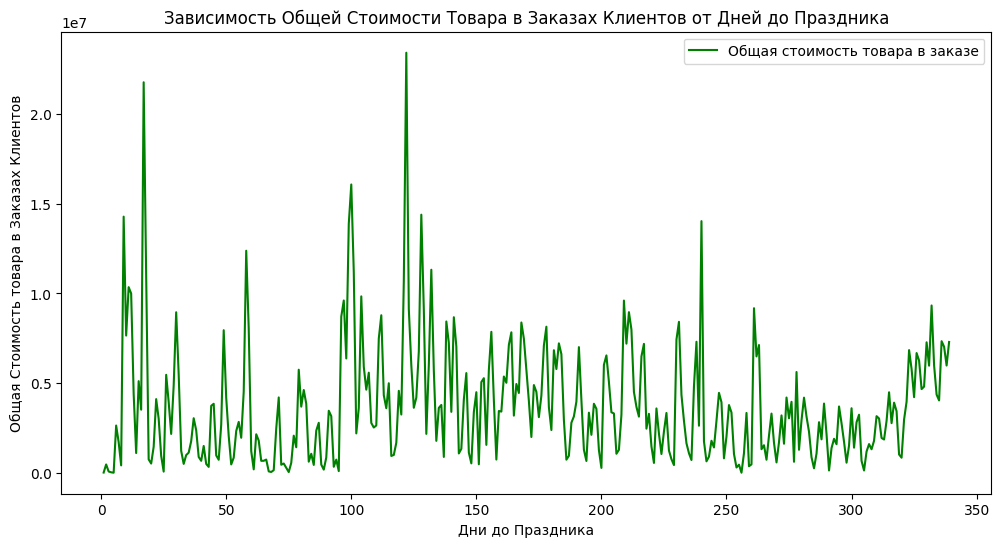

In [116]:
# Создание графика для зависимости метрики от дней до праздника
plt.figure(figsize=(12, 6))
sns.lineplot(x='days_until_holiday', y='price_total', data=aggregated_data_marketplace, label='Общая стоимость товара в заказе', color='green')
plt.title('Зависимость Общей Стоимости Товара в Заказах Клиентов от Дней до Праздника')
plt.xlabel('Дни до Праздника')
plt.ylabel('Общая Стоимость товара в Заказах Клиентов')
plt.legend()
plt.show()

Анализ данных за короткий период в один год ограничивает возможность выявления сезонных тенденций, однако позволяет выделить заметные пики в потребительском поведении клиентов. 

Основной пик покупок наблюдается за 15 дней до праздника, когда количество товаров достигает максимального значения. Этот пик свидетельствует о выраженной активности покупателей в этот период, вероятно, связанной с подготовкой к праздникам.

Наблюдаемые высокие значения за 53,125 дней до праздника могут свидетельствовать о дополнительных факторах, влияющих на покупательское решение.

Важно отметить, что обнаруженные пики в покупательском поведении могут быть также подвержены внешним влияниям, таким как экономическая ситуация в стране. Несмотря на ограниченность временных данных, проведенный анализ позволяет лучше понять динамику покупок клиентов и выделить временные интервалы, требующие дополнительного внимания при планировании маркетинговых стратегий и управлении запасами товаров.

**✔ Цель № 2:**

- Проанализировать как меняется покупательское поведение в разные дни недели и в выходные. 

Это может помочь определить оптимальные дни для проведения маркетинговых акций.

In [117]:
# Добавление столбца с днем недели (0 - понедельник, 1 - вторник, и так далее)
marketplace_total_df['day_of_week'] = marketplace_total_df['date'].dt.dayofweek

# Группировка данных по дню недели
day_of_week_data_marketplace = marketplace_total_df.groupby('day_of_week').agg({
    'quantity_total': 'sum',
    'price_total': 'sum',
    'orders_per_week': 'sum',
    # Другие интересующие вас метрики
}).reset_index()

# Маппинг для преобразования числовых значений дня недели в текстовый формат
day_mapping_marketplace = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}
day_of_week_data_marketplace['day_of_week'] = day_of_week_data_marketplace['day_of_week'].map(day_mapping_marketplace)

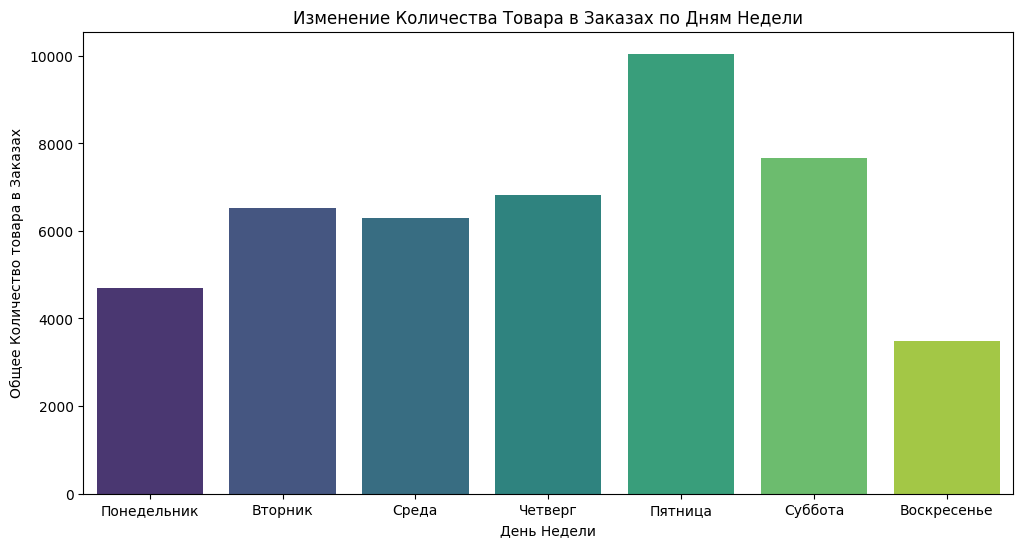

In [118]:
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='quantity_total', data=day_of_week_data_marketplace, palette='viridis')
plt.title('Изменение Количества Товара в Заказах по Дням Недели')
plt.xlabel('День Недели')
plt.ylabel('Общее Количество товара в Заказах')
plt.show()

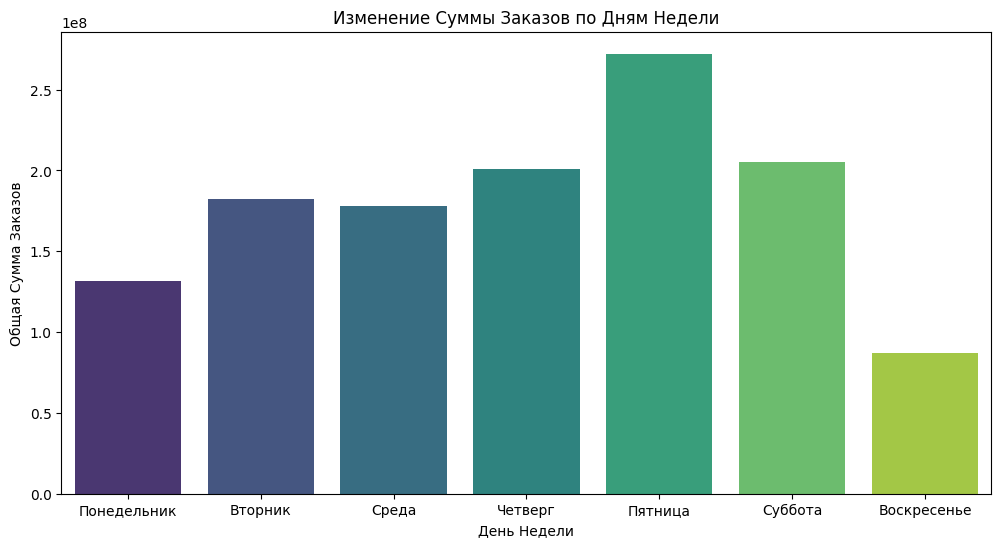

In [119]:
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='price_total', data=day_of_week_data_marketplace, palette='viridis')
plt.title('Изменение Суммы Заказов по Дням Недели')
plt.xlabel('День Недели')
plt.ylabel('Общая Сумма Заказов')
plt.show()

Анализ распределения количества товаров и распределения сумм заказов по дням недели выявил следующие тренды:

1. Пятница является лидером по количеству товаров в заказах
2. Суббота и четверг демонстрируют схожие показатели
3. Вторник и среда имеют более умеренные значения 
4. Понедельник имеет более умеренное значение
5. Воскресенье демонстрирует наименьшее количество товаров в заказах

Эти данные могут подсказывать о паттернах в покупательском поведении, что может быть полезно для определения оптимальных дней для проведения маркетинговых акций. Например, пятница, с ее высоким показателем, может быть привлекательным днем для акций или специальных предложений, в то время как в понедельник можно сосредоточить усилия на стимулировании покупок.

**✔ Цель № 3:**

- Исследовать и выявить изменения в активности покупок в зависимости от времени суток 

Оптимизациия маркетинговых стратегий и улучшения обслуживания клиентов.

In [120]:
# Группировка данных по времени суток
day_time_data_marketplace = marketplace_total_df.groupby('time_of_day').agg({
    'quantity_total': 'sum',
    'price_total': 'sum',
    'orders_per_week': 'sum',
    # Другие интересующие вас метрики
}).reset_index()

# Преобразование числовых значений времени суток в текстовый формат
time_of_day_mapping = {0: 'Рабочее время', 1: 'Послерабочее время', 2: 'Ночное время'}
day_time_data_marketplace['time_of_day'] = day_time_data_marketplace['time_of_day'].map(time_of_day_mapping)

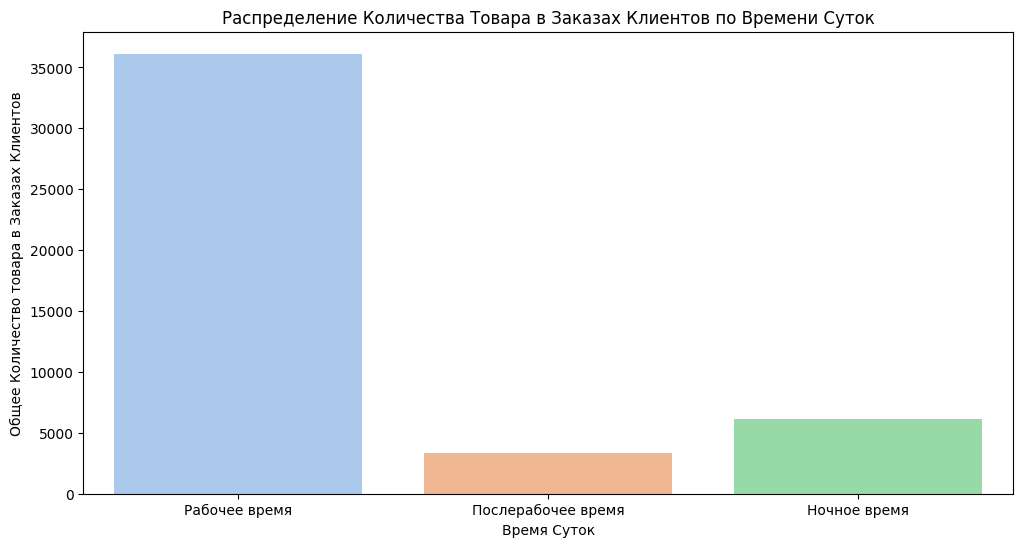

In [121]:
# Визуализация данных по времени суток
plt.figure(figsize=(12, 6))
sns.barplot(x='time_of_day', y='quantity_total', data=day_time_data_marketplace, palette='pastel')
plt.title('Распределение Количества Товара в Заказах Клиентов по Времени Суток')
plt.xlabel('Время Суток')
plt.ylabel('Общее Количество товара в Заказах Клиентов')
plt.show()


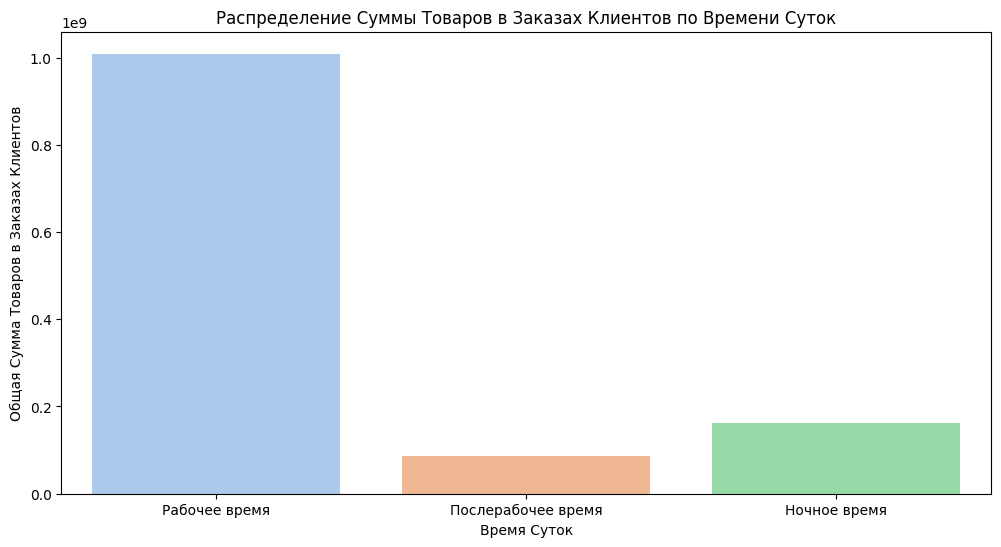

In [122]:
# Визуализация данных по времени суток
plt.figure(figsize=(12, 6))
sns.barplot(x='time_of_day', y='price_total', data=day_time_data_marketplace, palette='pastel')
plt.title('Распределение Суммы Товаров в Заказах Клиентов по Времени Суток')
plt.xlabel('Время Суток')
plt.ylabel('Общая Сумма Товаров в Заказах Клиентов')
plt.show()

Анализируя распределение покупок по часам в течение суток, можно сделать следующие выводы:

- Рабочее время (6:00 - 18:00). В этот период наблюдается наивысшее количество покупок и общая сумма продаж. Вероятно, это связано с активностью клиентов в рабочее время, когда они имеют доступ к интернет-магазину и могут совершать покупки в перерывах между рабочими обязанностями.

- Послерабочее время (18:00 - 24:00). В этот период наблюдается снижение активности клиентов, как в количестве покупок, так и в общей сумме продаж. Возможно, люди предпочитают отдыхать или проводить свободное время вне совершения покупок.

- Ночное время (0:00 - 6:00). В это время наблюдается самое низкое количество покупок и минимальная общая сумма продаж. Это может быть связано с тем, что большинство людей спит в этот период и не совершает онлайн-покупок.

Эти выводы могут быть полезны для оптимизации маркетинговых стратегий и управления ресурсами в разные часы суток.

**✔ Цель № 4:**

- Анализ того, через сколько дней в среднем клиенты совершают следующую покупку.

Анализ времени между последовательными покупками позволяет определить средний период, через который клиенты совершают следующую покупку. В среднем клиенты проявляют активность и осуществляют следующую покупку через определенный промежуток времени, что может быть ключевым фактором для оптимизации стратегий удержания клиентов и планирования маркетинговых кампаний. Этот анализ предоставляет более глубокое понимание поведения клиентов и может служить основой для создания персонализированных стратегий взаимодействия с аудиторией.

In [123]:
# Группировка данных по значениям столбца days_next_purchase и вычисление среднего
average_days_next_purchase_marketplace = marketplace_total_df.groupby('days_next_purchase')['client_id'].count().mean()

# Вывод результата
print(f"В среднем клиенты совершают следующую покупку через {average_days_next_purchase_marketplace:.2f} дней.")

В среднем клиенты совершают следующую покупку через 96.11 дней.


In [133]:
# Группировка данных по значениям столбца days_next_purchase и вычисление медианы
median_days_next_purchase_marketplace = marketplace_total_df.groupby('days_next_purchase')['client_id'].count().median()

# Вывод результата
print(f"В медиане клиенты совершают следующую покупку через {median_days_next_purchase_marketplace:.2f} дней.")

В медиане клиенты совершают следующую покупку через 6.00 дней.


**✔ Цель № 5:**

- Анализ сегментации клиентов

Определение постоянных клиентов и новых клиентов позволяет лучше понять структуру клиентской базы и выявить ценные сегменты. Этот анализ направлен на выявление тенденций в поведении клиентов и может служить основой для принятия более таргетированных маркетинговых решений.

In [124]:
# Подсчет количества заказов для каждого клиента
order_count_per_client_marketplace = marketplace_total_df.groupby('client_id')['orders_per_month'].sum()

# Определение постоянных клиентов(топ 10%)
top_clients_marketplace = order_count_per_client_marketplace.sort_values(ascending=False).head(int(0.1 * len(order_count_per_client_marketplace)))

# Определение новых клиентов (клиенты, у которых есть только один заказ)
new_clients_marketplace = order_count_per_client_marketplace[order_count_per_client_marketplace == 1]

# Подсчет пропорции 'холодных'(новых) и постоянных клиентов
total_clients_marketplace = len(order_count_per_client_marketplace)
new_clients_proportion_marketplace = len(new_clients_marketplace) / total_clients_marketplace
loyal_clients_proportion_marketplace = 1 - new_clients_proportion_marketplace

# Вывод результатов
print(f"Пропорция новых клиентов: {new_clients_proportion_marketplace:.2%}")
print(f"Пропорция постоянных клиентов: {loyal_clients_proportion_marketplace:.2%}")

Пропорция новых клиентов: 67.74%
Пропорция постоянных клиентов: 32.26%


Примерно 67.74% клиентов в выборке являются новыми, в то время как 32.26% - постоянными. Это может указывать на необходимость усиления усилий по удержанию клиентов и повышению лояльности среди тех, кто уже совершил покупки. Работа с программами лояльности, персонализированными предложениями или скидками для постоянных клиентов может быть эффективным способом увеличить долю постоянных клиентов в общей клиентской базе. Также стоит дополнительно изучить причины, по которым новые клиенты не становятся постоянными, чтобы оптимизировать маркетинговые стратегии и улучшить клиентский опыт.